In [1]:
import sys
sys.path.append("../src")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import toml
import os
import re
import json

import seaborn as sns
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("colorblind"))
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from wordcloud import WordCloud
from IPython.display import JSON
from collections import Counter
from tqdm import tqdm
from pathlib import Path

from sapsam import parser, constants, detector, filters
from sapsam.filters import DataFilter

pd.set_option('display.max_rows', None, 'display.max_columns', None)

In [3]:
# mappings for namespaces and element types
with open(constants.SRC_ROOT / 'mappings.json') as json_file:
    mappings = json.load(json_file)

# Read Data

Let's first read in the meta data of all models in the dataset.

In [4]:
df_meta = parser.parse_model_metadata()
df_meta.head()

100%|███████████████████████████████████████████████████████████████████████████████| 103/103 [02:51<00:00,  1.66s/it]


revision_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  5ed1535c95a342f4a414dd8c9b1b7df8   
1ba744cbcafb46c2a52482e36498a9bf  301bfb5af53c431a830a6e435de6a590   
1ba7587b3191422fb03a0e9ba92cebff  ac3baa3e59ca476396b4affa8e900c6f   
1ba758f87e744ff0bcb3119887cac8cc  da11513a93224fbbb2c34ef9c5cfcaa9   
1ba77121c3be44d6bd0b354727f9707b  70d06e82d8c344edab8b041f8b03161a   

                                                   organization_id  \
model_id                                                             
1ba74449e9354d0c9d4798b4a6e915d0  6c96d0b6e5e14eeaa9848f953a94e5f8   
1ba744cbcafb46c2a52482e36498a9bf  8af3fc1bb4b74e7c8c4089e4921d9056   
1ba7587b3191422fb03a0e9ba92cebff  36fbc1ee23334e1ab987b07d2108eef2   
1ba758f87e744ff0bcb3119887cac8cc  574093f96e5e4ff09a8b1f24eeb70284   
1ba77121c3be44d6bd0b354727f9707b  ff66cd6b779c44bba88ade8952d7e626   

                                             datetime description  \
model_id                                                            
1ba74449e9354d0c9d4798b4a6e915d0  2019-03-19 11:36:50         NaN   
1ba744cbcafb46c2a52482e36498a9bf  2020-03-23 17:26:03         NaN   
1ba7587b3191422fb03a0e9ba92cebff  2017-04-19 06:19:36         NaN   
1ba758f87e744ff0bcb3119887cac8cc  2021-02-21 13:14:32         NaN   
1ba77121c3be44d6bd0b354727f9707b  2020-06-30 07:12:48         NaN   

                                                                    name type  \
model_id                                                                        
1ba74449e9354d0c9d4798b4a6e915d0                                    Pivo  NaN   
1ba744cbcafb46c2a52482e36498a9bf                  Receipt of Application  NaN   
1ba7587b3191422fb03a0e9ba92cebff                710 BPMN Conference room  NaN   
1ba758f87e744ff0bcb3119887cac8cc                       ECU application p  NaN   
1ba77121c3be44d6bd0b354727f9707b  2.9.1 Elektronischer Auftrag erfassen   NaN   

                                                            namespace  
model_id                                                               
1ba74449e9354d0c9d4798b4a6e915d0  http://b3mn.org/stencilset/bpmn2.0#  
1ba744cbcafb46c2a52482e36498a9bf  http://b3mn.org/stencilset/bpmn2.0#  
1ba7587b3191422fb03a0e9ba92cebff  http://b3mn.org/stencilset/bpmn2.0#  
1ba758f87e744ff0bcb3119887cac8cc  http://b3mn.org/stencilset/bpmn2.0#  
1ba77121c3be44d6bd0b354727f9707b  http://b3mn.org/stencilset/bpmn2.0#

# Filtering example processes

The dataset includes the following vendor provided example processes.

In [5]:
len(df_meta)

1021471

In [6]:
#df_meta = DataFilter(df_meta)
#df_meta = df_meta.filter_data("example_processes")
#len(df_meta)

In [7]:
import json
with open(constants.SRC_ROOT / "prefilled_example_processes.json") as data_file:    
    examples = json.load(data_file)

Here is the list of all example processes names:

In [8]:
example_names = []
for batch in examples["example_processes"]:
    example_names.extend(batch["content"])
example_names = set(example_names)
example_names

{'Arbeitsmittel beschaffen',
 'BANF-zu-Bestellung',
 'Bestellung-zu-Lieferung',
 'Bewerber prüfen',
 'Bewerbungseingang',
 'Check quantity and quality',
 'Commande de pièces',
 'Contrôler la quantité et la qualité',
 'Delivery-to-Payment',
 "Donner l'équipement de travail",
 'Ebene  2 - Prozessbereich: Personalwesen',
 'Ebene 1 - Prozesslandkarte ACME AG',
 'Ebene 2 - Prozessbereich: Auftragsdurchführung',
 'Ebene 2 - Prozessbereich: Produktentwicklung',
 'Employee Onboarding',
 "Installation d'un employé",
 'Level  2 - Process Area: Human Resources',
 'Level 1 - Value Chain ACME AG',
 'Level 2 - Process Area: Order Processing',
 'Level 2 - Process Area: Product Development',
 'Lieferung-zu-Bezahlung',
 'Menge und Qualität überprüfen',
 'Mitarbeiter Onboarding',
 "Niveau 1 – Chaine de valeur d'ACME AG",
 'Niveau 2 - Processus de développement produit',
 'Niveau 2 - Processus de gestion des commandes',
 'Niveau 2 - Processus des Ressources Humaines',
 'Procure parts',
 'Procurement of W

Now let's take a look at the number of examples processes in the dataset (note that we decide this based on the process name which is more of a rough estimate rather than an accurate number):

In [9]:
df_meta_examples = df_meta[df_meta["name"].isin(example_names)]
len(df_meta_examples)

471496

This is the percentage of example process from the dataset:

In [10]:
len(df_meta_examples)/len(df_meta)

0.4615853019811625

This is the number of models in the dataset without example processes (again, based on process names):

In [11]:
len(df_meta)-len(df_meta_examples)

549975

And the percentage of models in the dataset without example processes:

In [12]:
(len(df_meta)-len(df_meta_examples))/len(df_meta)

0.5384146980188376

We apply the filter to perform the analysis on the dataset without examples processes:

In [13]:
df_meta = DataFilter(df_meta)
df_meta = df_meta.filter_data("example_processes")
len(df_meta)

549975

We see that the size of the dataset now matches the previous calculation of the number of models without example processes.

# Modeling notations

We want to examine the usage of modeling notations in the dataset.

Let's start with counting the number of models in different modeling notations.

In [14]:
df_notations = pd.DataFrame.from_dict(dict(Counter(df_meta["namespace"])),orient = "index")
df_notations.reset_index(inplace=True)
df_notations.columns = ["Notation","Frequency"]
df_notations.sort_values(by=['Frequency'], ascending=False, inplace=True, ignore_index=True)
df_notations

Notation  Frequency
0                 http://b3mn.org/stencilset/bpmn2.0#     404243
1                     http://b3mn.org/stencilset/epc#      32339
2     http://www.signavio.com/stencilsets/processmap#      22857
3                 http://b3mn.org/stencilset/bpmn1.1#      15636
4             http://b3mn.org/stencilset/UML2.2Class#      14953
5            http://signavio.com/stencilsets/dmn-1.0#      12612
6                http://b3mn.org/stencilset/petrinet#      11207
7          http://cisco.com/stencilset/archimate-2.1#      10956
8              http://b3mn.org/stencilset/UMLUseCase#      10228
9     http://www.signavio.com/stencilsets/organigram#       4568
10    http://b3mn.org/stencilset/bpmn2.0choreography#       4096
11    http://b3mn.org/stencilset/bpmn2.0conversation#       2788
12  http://www.fmc-modeling.org/stencilsets/fmcblo...       1398
13          http://signavio.com/stencilsets/cmmn-1.0#        999
14        http://b3mn.org/stencilset/coloredpetrinet#        385
15    http://www.signavio.com/stencilsets/journeymap#        287
16                http://b3mn.org/stencilset/yawl2.2#        238
17  http://www.signavio.com/stencilsets/processdoc...         86
18                  http://b3mn.org/stencilset/jbpm4#         76
19                 http://b3mn.org/stencilset/xforms#         20
20           http://b3mn.org/stencilset/chennotation#          3

We map the namespaces to the common names for the modeling notations.

In [15]:
d_namespaces = mappings["namespaces"]
d_namespaces_reverse = {}
for k,v in d_namespaces.items():
    d_namespaces_reverse[v]=k
df_notations = df_notations.replace({'Notation' : d_namespaces})
df_notations

Notation  Frequency
0                         BPMN 2.0     404243
1                              EPC      32339
2                      Value Chain      22857
3                         BPMN 1.1      15636
4                    UML 2.2 Class      14953
5                          DMN 1.0      12612
6                        Petri Net      11207
7                    ArchiMate 2.1      10956
8                     UML Use Case      10228
9                       Organigram       4568
10           BPMN 2.0 Choreography       4096
11           BPMN 2.0 Conversation       2788
12               FMC Block Diagram       1398
13                        CMMN 1.0        999
14                             CPN        385
15                     Journey Map        287
16                        YAWL 2.2        238
17  Process Documentation Template         86
18                          jBPM 4         76
19                          XForms         20
20                   Chen Notation          3

And we aggregate modeling notations which are used for less than 100 models in "Other".

In [16]:
other_dict={
 'Process Documentation Template':'Other',
 'jBPM 4':'Other',
 'XForms':'Other',
 'Chen Notation':'Other'
}
last_x = len(other_dict)
df_notations_upper = df_notations.iloc[:-last_x,:]
df_notations_other = df_notations.iloc[len(df_notations)-last_x:,:].replace({'Notation': other_dict}).groupby('Notation').sum().reset_index()
df_notations=pd.concat([df_notations_upper,df_notations_other],ignore_index=True)
df_notations.tail()

Notation  Frequency
13     CMMN 1.0        999
14          CPN        385
15  Journey Map        287
16     YAWL 2.2        238
17        Other        185

Now we visualize the number of models in different modeling notations.

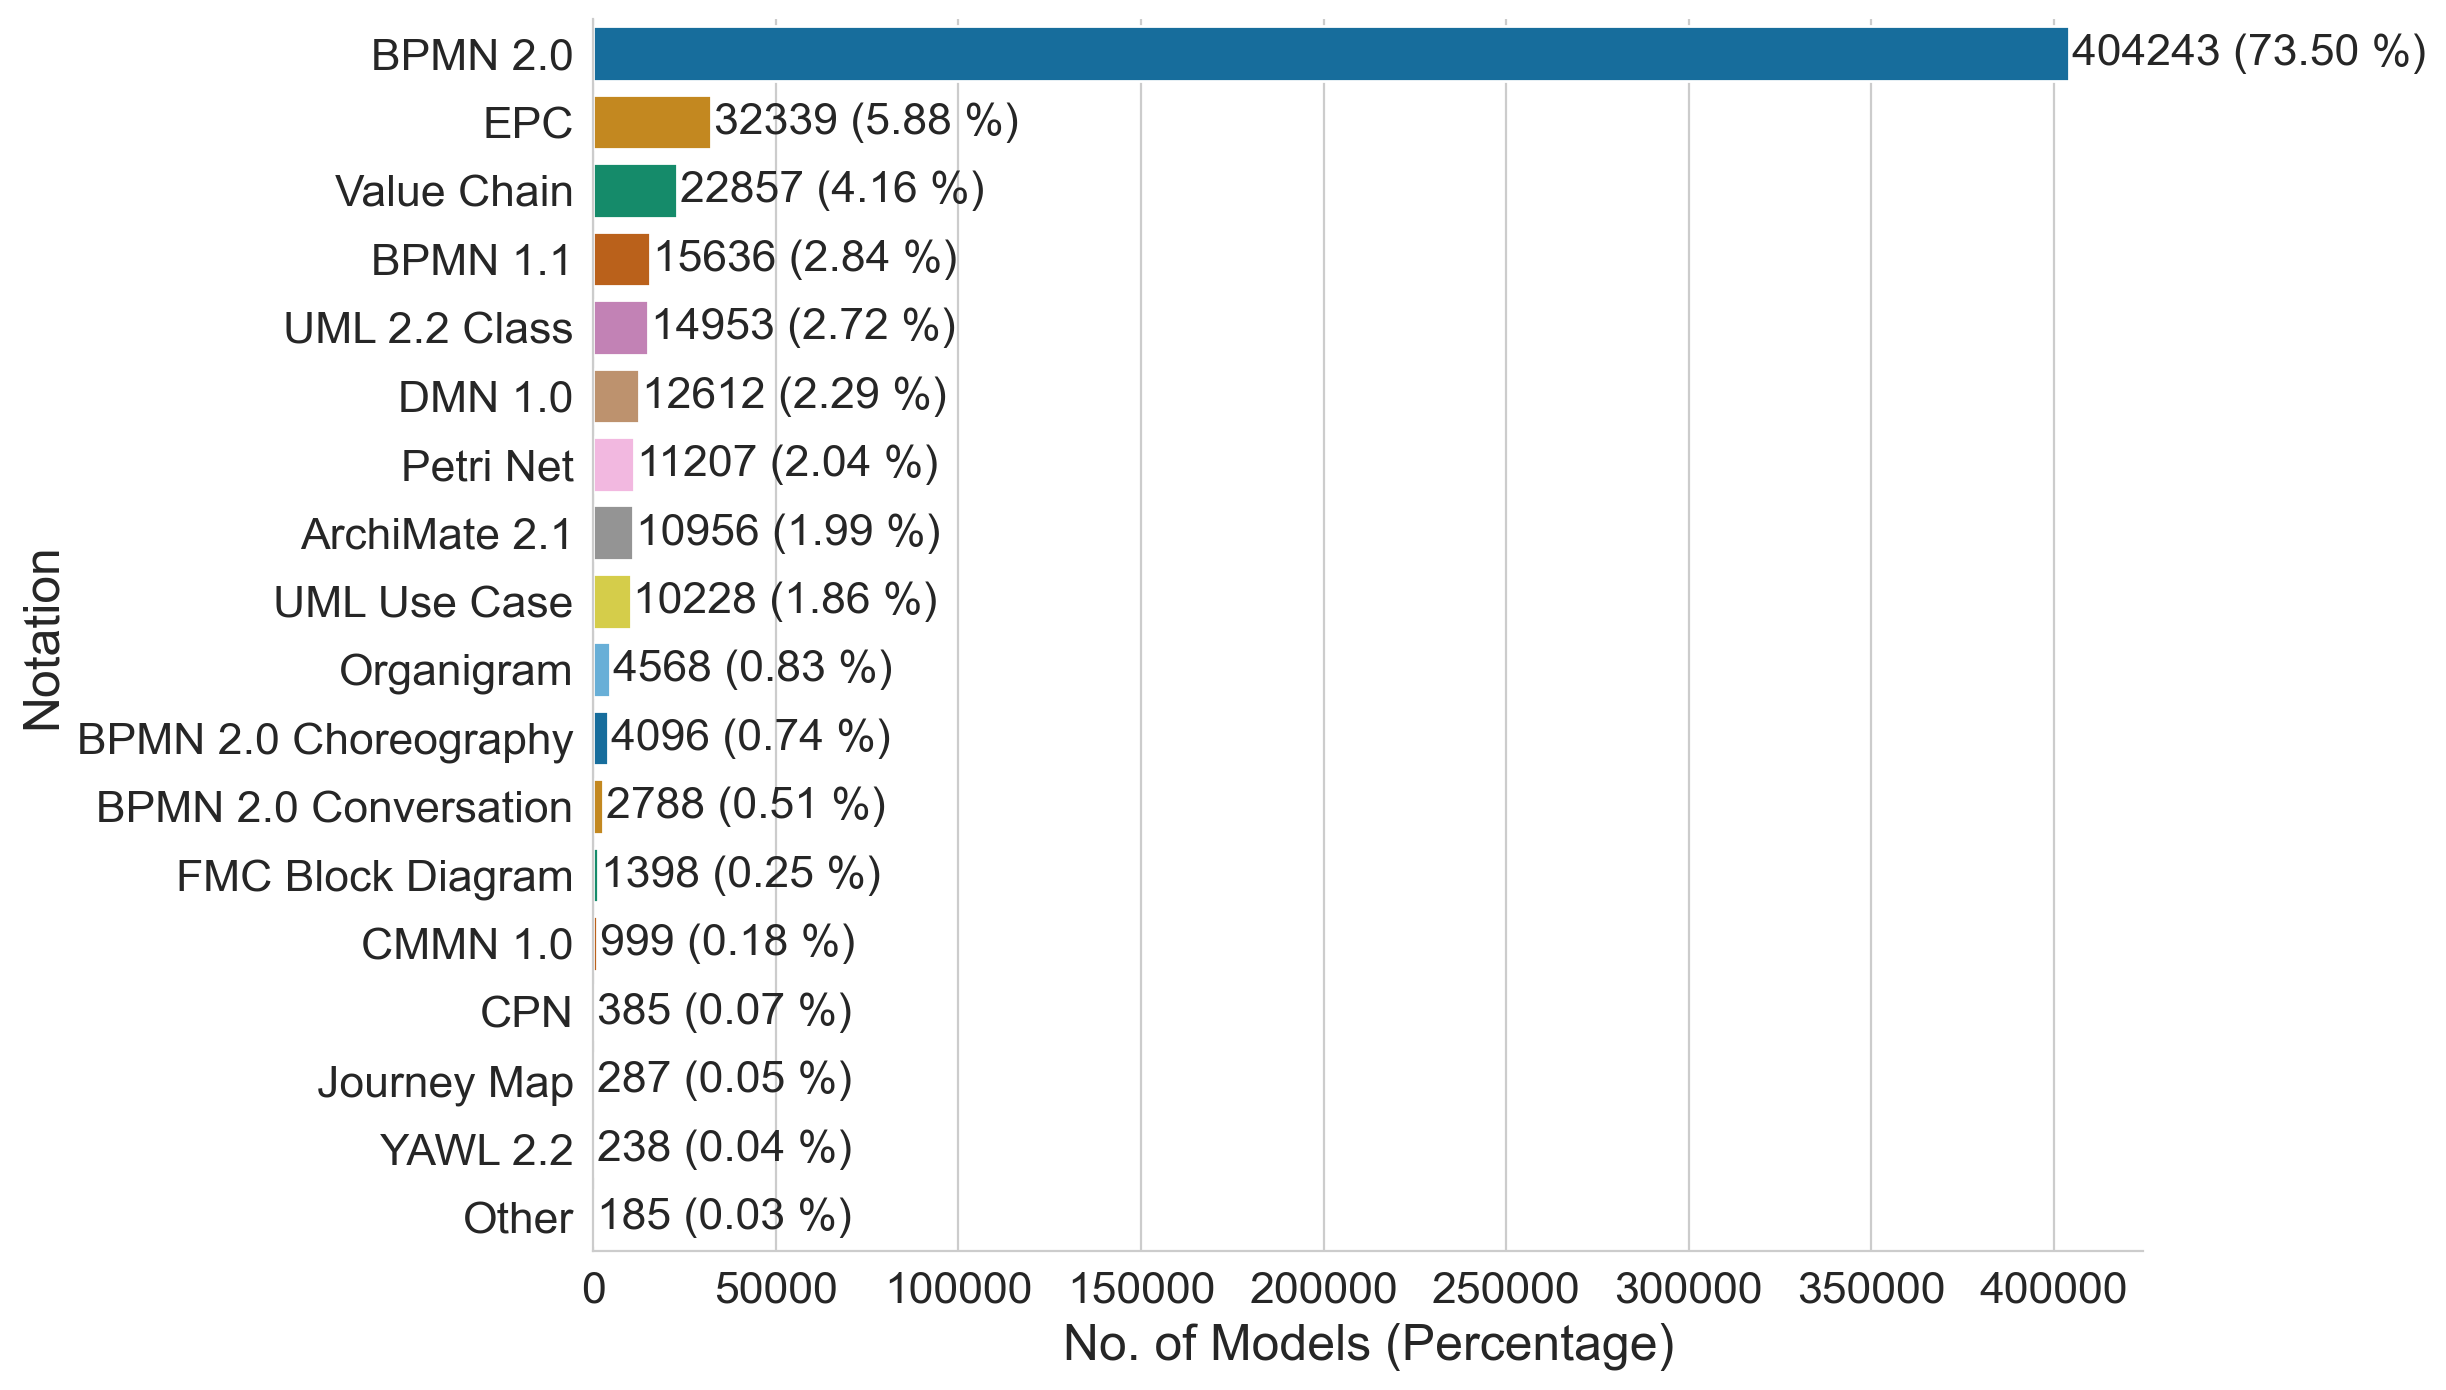

In [17]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 16})
ax=sns.barplot(x="Frequency", y="Notation", data=df_notations, estimator = np.max,ci = 0, palette = sns.color_palette("colorblind"))
# ax=sns.barplot(x="Frequency", y="Notation", hue="Notation", data=df_notations, estimator = np.max, errorbar=('ci', 0), legend=False)
sns.despine()
ax.bar_label(ax.containers[0], label_type='edge', padding=1, labels=[f'{val} ({val/ len(df_meta) * 100.0:.2f} %)' for val in df_notations["Frequency"]])
ax.set_xlabel('No. of Models (Percentage)', fontsize=18)
ax.set_ylabel('Notation', fontsize=18)
# ax.set_xlim(0,700000)
plt.savefig(constants.FIGURES_ROOT / 'notations.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

By using the datetime column, we can also consider the creation of models in different notations over time.

In [18]:
df_meta.datetime = pd.to_datetime(df_meta.datetime)

These are the first and the last created models in the dataset:

In [19]:
df_meta.sort_values('datetime').head(1)

revision_id  \
model_id                                                             
c1f9781d06594f068bee14f96d6744f3  43fe80a91c114d3ca121e8e8fb03a0a6   

                                                   organization_id  \
model_id                                                             
c1f9781d06594f068bee14f96d6744f3  c78f482cc9d54a278154a3d1671450db   

                                            datetime description  \
model_id                                                           
c1f9781d06594f068bee14f96d6744f3 2011-12-01 23:11:10         NaN   

                                              name       type  \
model_id                                                        
c1f9781d06594f068bee14f96d6744f3  Ampel - Lösung 1  Petrinets   

                                                             namespace  
model_id                                                                
c1f9781d06594f068bee14f96d6744f3  http://b3mn.org/stencilset/petrinet#

In [20]:
df_meta.sort_values('datetime').tail(1)

revision_id  \
model_id                                                             
0507df8deb7847e0a97d7515663e168d  9c6d4bceab634d7ca854edb71d3b5f0b   

                                                   organization_id  \
model_id                                                             
0507df8deb7847e0a97d7515663e168d  30da146aae4842cfab909b9723944f7a   

                                            datetime description  \
model_id                                                           
0507df8deb7847e0a97d7515663e168d 2021-09-22 03:19:14         NaN   

                                                                          name  \
model_id                                                                         
0507df8deb7847e0a97d7515663e168d  OSPCC Related Queries-As-Is Model  (Updated)   

                                 type                            namespace  
model_id                                                                    
0507df8deb7847e0a97d7515663e168d  NaN  http://b3mn.org/stencilset/bpmn2.0#

Let's check the creation of models over time for the five most used notations.

In [21]:
selected_notations = [d_namespaces_reverse[i] for i in df_notations.Notation.values[:5]]
df_meta_selected = df_meta[df_meta.namespace.isin(selected_notations) ].copy()
df_meta_selected['Count']= 1
df_meta_selected=df_meta_selected[['datetime','Count','namespace']].sort_values('datetime')
df_meta_selected.set_index('datetime', inplace=True)

We count the number of models created per year.

In [22]:
df_meta_selected = df_meta_selected.groupby('namespace').resample('Y').sum().reset_index()
df_meta_selected['Year'] = df_meta_selected['datetime'].apply(lambda x:x.year)

To ensure index consistency in the plot, we pivot the table and fill the count for missing years with 0. This step is a precaution for the case when a notation hasn't been created for a given year.

In [23]:
df_meta_selected = df_meta_selected.pivot_table(index='Year', columns='namespace', values='Count', fill_value=0)
df_meta_selected = df_meta_selected.reset_index().melt(var_name='namespace', value_name='Count', id_vars='Year')
df_meta_selected = df_meta_selected[['namespace', 'Count', 'Year']]

df_meta_selected = df_meta_selected.replace({'namespace' : d_namespaces})
df_meta_selected

namespace   Count  Year
0   UML 2.2 Class       0  2012
1   UML 2.2 Class       0  2013
2   UML 2.2 Class       0  2014
3   UML 2.2 Class     193  2015
4   UML 2.2 Class    1127  2016
5   UML 2.2 Class    1773  2017
6   UML 2.2 Class    1669  2018
7   UML 2.2 Class    1174  2019
8   UML 2.2 Class    3860  2020
9   UML 2.2 Class    5157  2021
10       BPMN 1.1       0  2012
11       BPMN 1.1       0  2013
12       BPMN 1.1       0  2014
13       BPMN 1.1     205  2015
14       BPMN 1.1     596  2016
15       BPMN 1.1    1400  2017
16       BPMN 1.1    2418  2018
17       BPMN 1.1    2200  2019
18       BPMN 1.1    3421  2020
19       BPMN 1.1    5396  2021
20       BPMN 2.0       4  2012
21       BPMN 2.0       0  2013
22       BPMN 2.0       0  2014
23       BPMN 2.0    4391  2015
24       BPMN 2.0   17867  2016
25       BPMN 2.0   39066  2017
26       BPMN 2.0   66351  2018
27       BPMN 2.0   81634  2019
28       BPMN 2.0   93875  2020
29       BPMN 2.0  101055  2021
30            EPC       0  2012
31            EPC       1  2013
32            EPC       0  2014
33            EPC    1451  2015
34            EPC    2617  2016
35            EPC    4806  2017
36            EPC    6163  2018
37            EPC    5646  2019
38            EPC    7403  2020
39            EPC    4252  2021
40    Value Chain       0  2012
41    Value Chain       0  2013
42    Value Chain       0  2014
43    Value Chain     288  2015
44    Value Chain    1389  2016
45    Value Chain    2247  2017
46    Value Chain    4462  2018
47    Value Chain    3901  2019
48    Value Chain    6627  2020
49    Value Chain    3943  2021

Since the number of models created before 2015 in the dataset is rather small, we visualize the numbers starting in 2015. Also, the dataset only contains models until September 2021, so we exclude 2021, too.

In [24]:
sum(df_meta['datetime'].apply(lambda x: x.year)<2015)

24

In [25]:
df_meta_selected=df_meta_selected[df_meta_selected['Year']>=2015]
df_meta_selected=df_meta_selected[df_meta_selected['Year']<2021]
df_meta_selected.head()

namespace  Count  Year
3  UML 2.2 Class    193  2015
4  UML 2.2 Class   1127  2016
5  UML 2.2 Class   1773  2017
6  UML 2.2 Class   1669  2018
7  UML 2.2 Class   1174  2019

In [26]:
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

<Figure size 2000x1000 with 0 Axes>

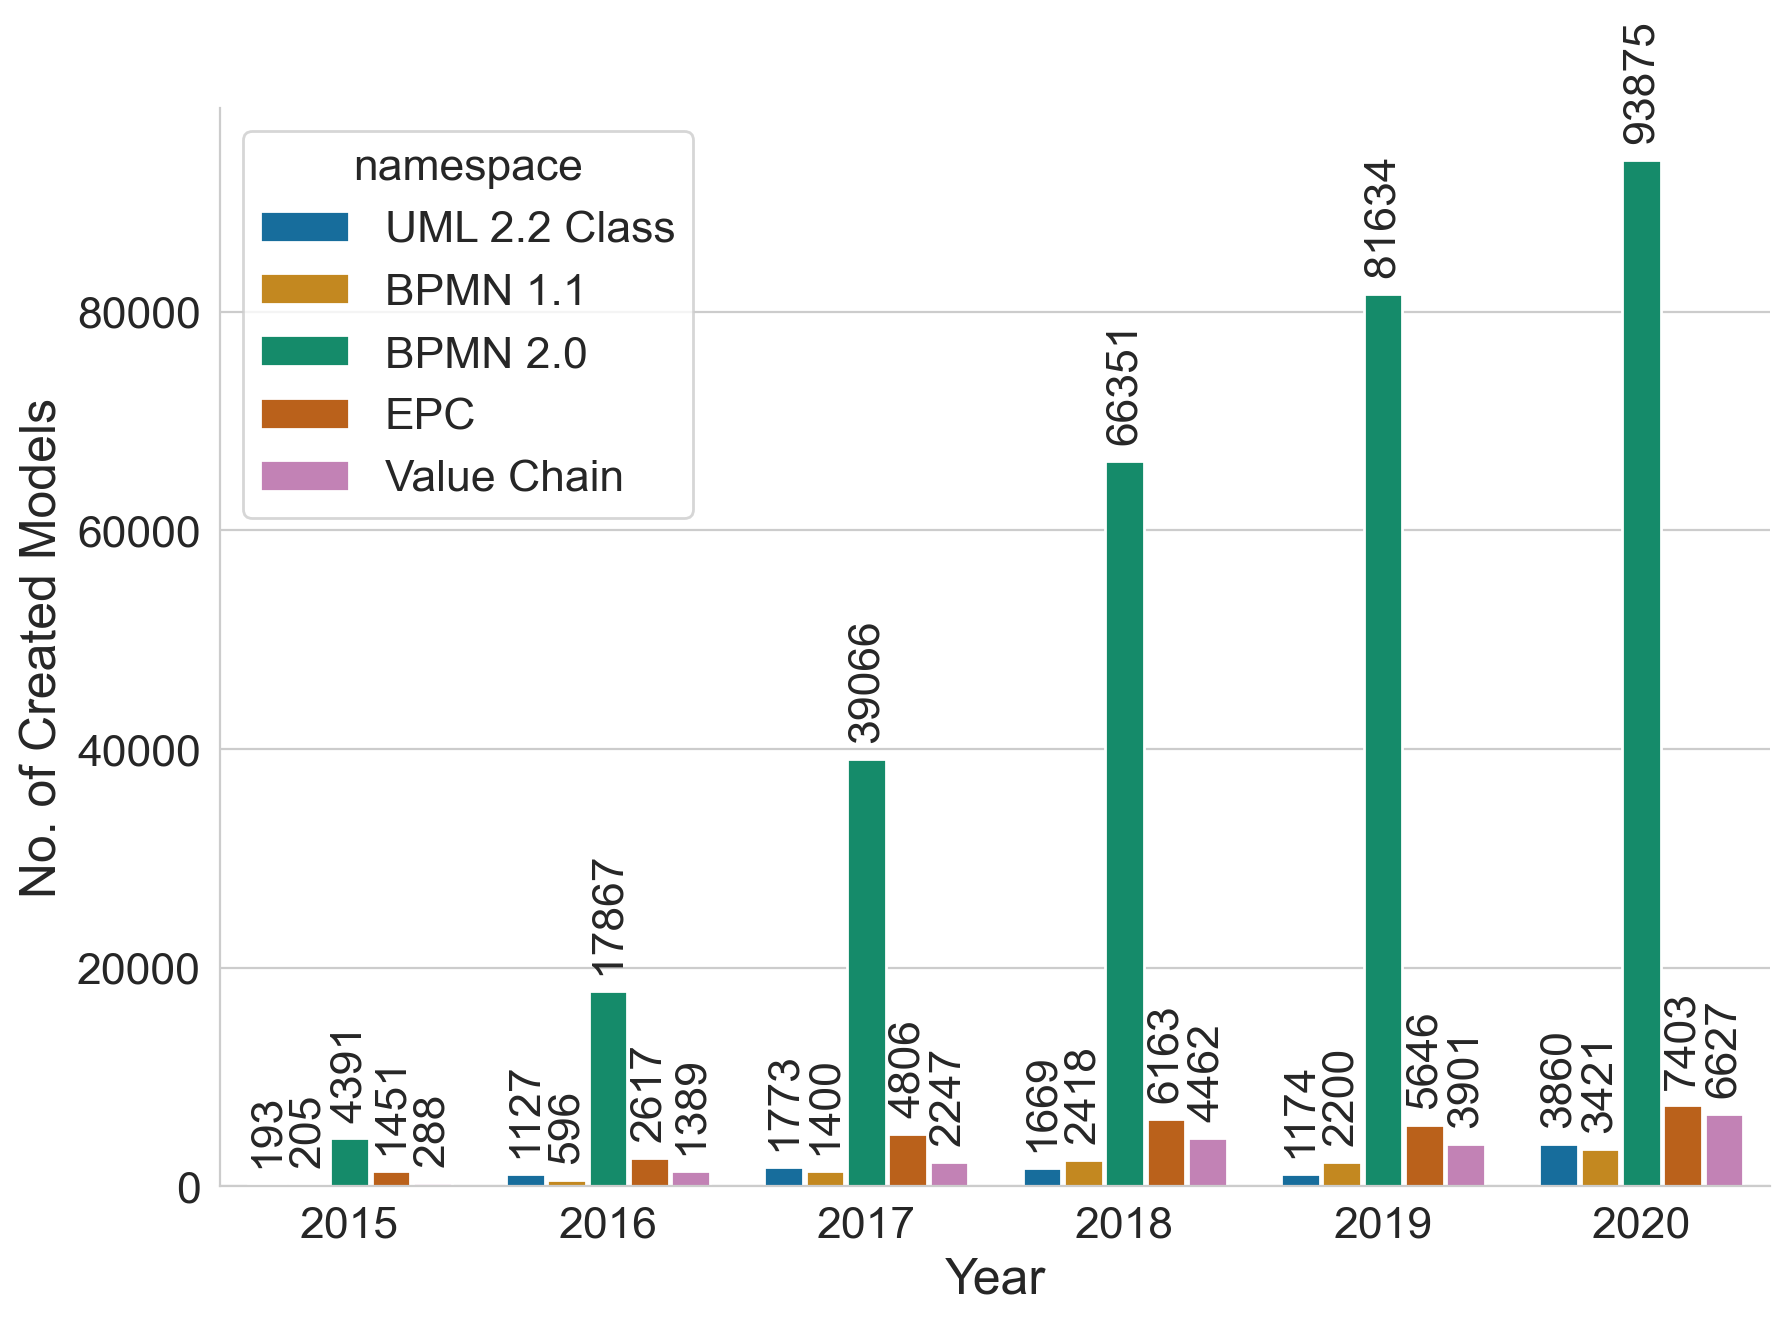

In [27]:
plt.figure(figsize=(20,10))
fig, ax = plt.subplots(figsize=(10,7))
sns.barplot(data=df_meta_selected,x='Year', y='Count', hue='namespace',ax=ax,palette=sns.color_palette("colorblind"))
#plt.legend(title='', loc='upper left')
change_width(ax, .15)
for container in ax.containers:
    ax.bar_label(container, padding = 6, rotation='vertical')
ax.set_xlabel('Year',fontsize=18)
ax.set_ylabel('No. of Created Models',fontsize=18)
sns.despine()

We can also visualize this as stacked plot.

In [28]:
selected_notations_short = [d_namespaces[n] for n in selected_notations]
d_stacked = dict()
for n in selected_notations_short:
    d_stacked[n] = df_meta_selected[df_meta_selected["namespace"]==n]["Count"].values
df_stacked = pd.DataFrame(d_stacked, index=df_meta_selected.Year.unique())
df_stacked.sort_index(ascending=False,inplace=True)
df_stacked

BPMN 2.0   EPC  Value Chain  BPMN 1.1  UML 2.2 Class
2020     93875  7403         6627      3421           3860
2019     81634  5646         3901      2200           1174
2018     66351  6163         4462      2418           1669
2017     39066  4806         2247      1400           1773
2016     17867  2617         1389       596           1127
2015      4391  1451          288       205            193

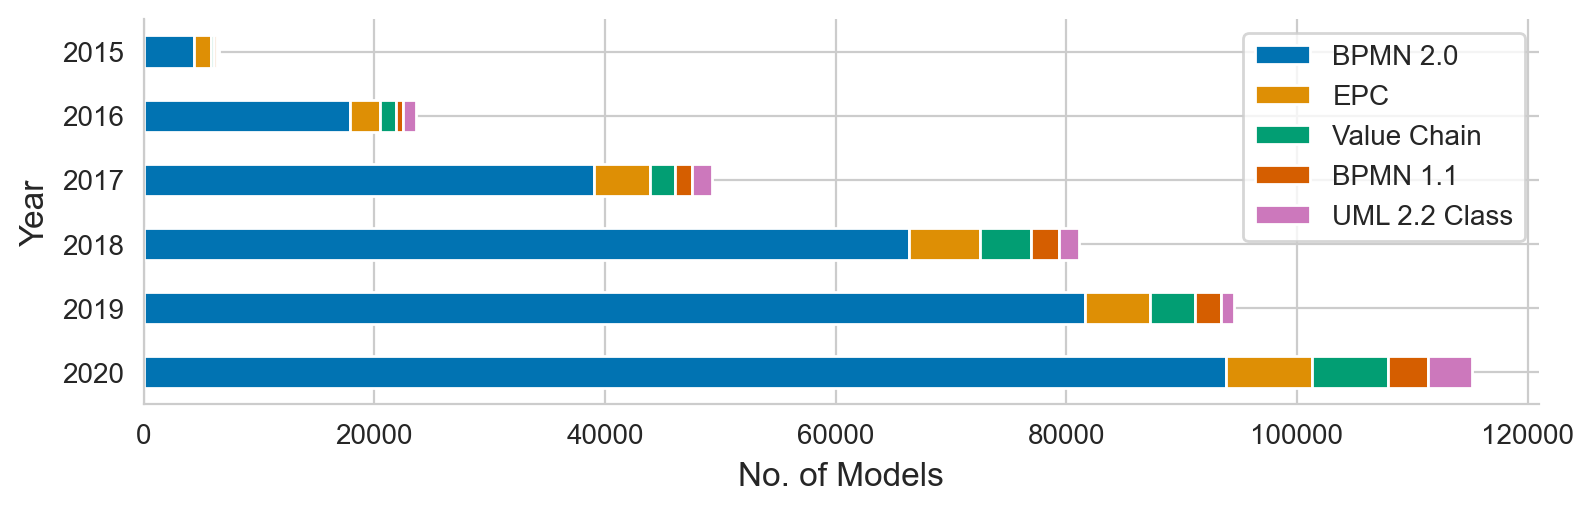

In [29]:
plt.rcParams.update({'font.size': 10})
ax = df_stacked.plot(kind='barh', stacked=True,figsize=(9,2.5))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel("No. of Models",fontsize=12)
ax.set_ylabel("Year",fontsize=12)
plt.savefig(constants.FIGURES_ROOT / 'notations_over_time.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

# Parse BPMN 2.0 models

For further analysis, we concentrate on BPMN 2.0 models as primary used notation.

In [30]:
df_meta_bpmn = df_meta[df_meta.namespace == constants.BPMN2_NAMESPACE]

Number of BPMN 2.0 models:

In [31]:
len(df_meta_bpmn)

404243

We use the BPMNModelParser to parse the BPMN 2.0 models. In case, we have already parsed them, we load the parsed data from the pkl file.

In [32]:
p = parser.BpmnModelParser() # comment this line if you have already created the pkl file
df_bpmn = p.parse_model_elements() # comment this line if you have already created the pkl file
df_bpmn.to_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # comment this line if you have already created the pkl file
# df_bpmn = pd.read_pickle(constants.DATA_INTERIM / "bpmn_elements.pkl") # uncomment this line if you have already created the pkl file
df_bpmn.head()

100%|███████████████████████████████████████████████████████████████████████████████| 103/103 [15:44<00:00,  9.17s/it]


category  \
model_id                         element_id                                                    
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD        MessageFlow   
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE               Pool   
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803               Lane   
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  StartMessageEvent   
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262       SequenceFlow   

                                                                                          label  
model_id                         element_id                                                      
1ba74449e9354d0c9d4798b4a6e915d0 sid-7D3363B0-6AAD-4B13-AFAD-B3F2525191FD                        
                                 sid-00A06776-842A-40B5-9F67-A7A2B247CBAE             Konobar\n  
                                 sid-3E27602D-0560-44E1-8089-4FC264FA9803                        
                                 sid-6E3EE415-179F-4D56-AA73-B8D0CC2B5246  Narudžba primljena\n  
                                 sid-ED915395-D5F6-44D6-80C5-11D279EBC262

Number of BPMN 2.0 models from the parser:

In [33]:
index = df_bpmn.index.get_level_values('model_id')
index.nunique()

605506

The difference in the number of BPMN 2.0 models shows that there are some empty BPMN 2.0 models in the dataset which do not contain any elements. 

The total number of elements of all BPMN 2.0 models is:

In [34]:
len(df_bpmn)

28293762

# Languages

We use spaCy to detect the language of a model. More specifically, we use a model's element labels to decide on its language.

In [35]:
try:
    nlp = spacy.load("en_core_web_sm")
    print("Package already installed")
except:
    print("Installing package...")
    !python -m spacy download en_core_web_sm > /dev/null
    #!pip install update -U pydantic==1.10.8
    print("\033[92m\u2713\033[0m Download and installation successful")

Installing package...

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
✓ Download and installation successful


In [36]:
ld = detector.ModelLanguageDetector(0.8) # comment this line if you have already created the pkl file
df_language = ld.get_detected_natural_language_from_bpmn_model(df_bpmn) # comment this line if you have already created the pkl file
df_language.to_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # comment this line if you have already created the pkl file
# df_language = pd.read_pickle(constants.DATA_INTERIM / "bpmn_languages.pkl") # uncomment this line if you have already created the pkl file
df_language.head()

100%|███████████████████████████████████████████████████████████████████████| 605506/605506 [2:18:50<00:00, 72.69it/s]


label  \
model_id                                                                              
1ba74449e9354d0c9d4798b4a6e915d0   Konobar\n Narudžba primljena\n Narudžba / kup...   
1ba744cbcafb46c2a52482e36498a9bf   Reject  Accept No Yes Applicant ACME AG Head ...   
1ba7587b3191422fb03a0e9ba92cebff   Yes No Organization\n Employee Meeting confir...   
1ba758f87e744ff0bcb3119887cac8cc   A student visits ACBT Direct to ECU SL Direct...   
1ba77121c3be44d6bd0b354727f9707b   Kunde  "DESADV"\n geht ein Auftrags-\nE-Mail ...   

                                 detected_natural_language  
model_id                                                    
1ba74449e9354d0c9d4798b4a6e915d0                        hr  
1ba744cbcafb46c2a52482e36498a9bf                        en  
1ba7587b3191422fb03a0e9ba92cebff                        en  
1ba758f87e744ff0bcb3119887cac8cc                        en  
1ba77121c3be44d6bd0b354727f9707b                        de

Let's plot the use of different languages across the dataset.

In [37]:
from langcodes import *
def get_language_from_code(code):
    return Language.make(language=code).display_name()

In [38]:
d_lang =  dict(Counter(df_language["detected_natural_language"]))
df_lang = pd.DataFrame.from_dict(d_lang,orient="index")
df_lang = df_lang.reset_index().rename(columns={"index": "Language",0: "No. of Models"})
df_lang["Language"] = df_lang["Language"].apply(lambda x: get_language_from_code(x))
df_lang.sort_values("No. of Models",ascending=False,inplace=True)
df_lang.reset_index(inplace=True)
df_lang.drop("index",inplace=True,axis=1)
df_lang

Language  No. of Models
0                      English         347704
1                       German         158962
2                      Italian          19325
3                      Spanish          17309
4                       French           9482
5                     Croatian           8303
6                   Portuguese           6667
7                     Estonian           4891
8                        Dutch           4855
9                    Slovenian           4176
10  Unknown language [UNKNOWN]           4000
11                    Romanian           3405
12                  Indonesian           3038
13                     Swedish           2270
14                      Polish           1579
15                   Hungarian           1541
16                       Greek           1498
17                      Danish            672
18                     Catalan            560
19                   Norwegian            544
20                     Finnish            455
21                   Afrikaans            437
22                  Vietnamese            428
23                       Welsh            427
24                     Turkish            415
25                    Japanese            397
26                     Latvian            291
27                       Czech            285
28                     Tagalog            266
29    Unknown language [zh-cn]            210
30                      Somali            209
31                      Slovak            204
32                    Albanian            181
33                     Russian            169
34                      Korean            109
35                  Macedonian             81
36                  Lithuanian             74
37                     Swahili             40
38                     Persian             38
39                      Arabic              4
40                        Thai              2
41                   Bulgarian              2
42                   Ukrainian              1

We only plot the 10 most common languages.

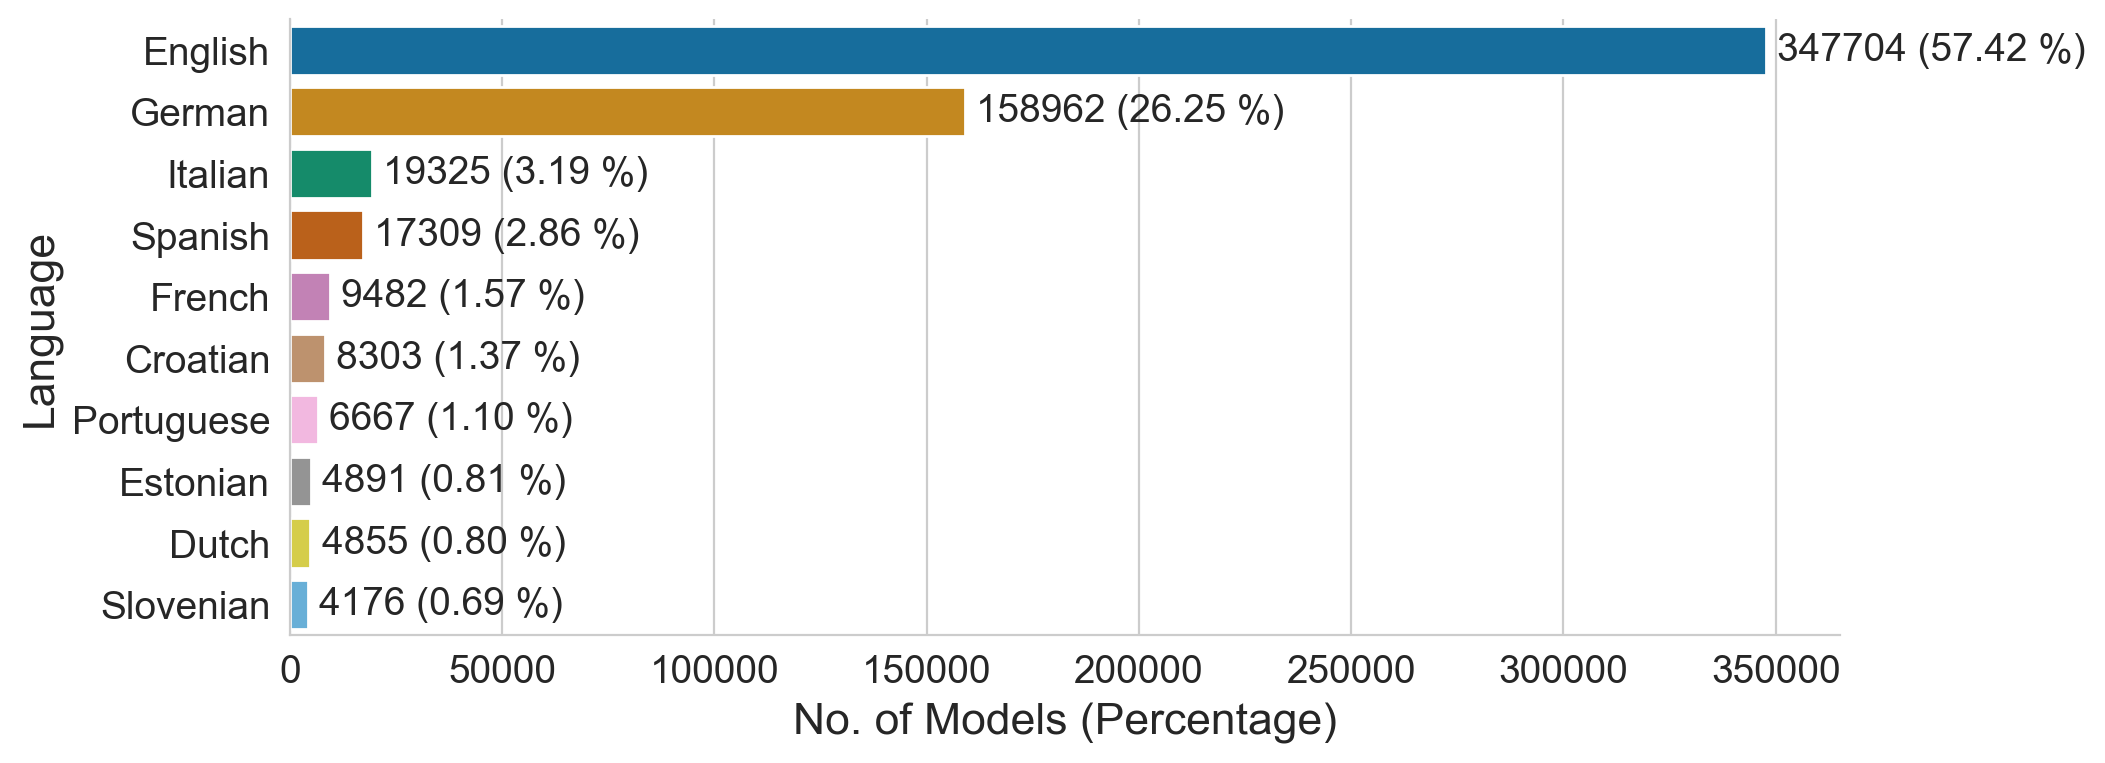

In [39]:
nr_most_common = 10
total = df_lang['No. of Models'].sum()
df_lang = df_lang.iloc[:10]
plt.figure(figsize=(10,4))
plt.rcParams.update({'font.size': 14})
ax = sns.barplot(x="No. of Models", y="Language", data=df_lang,palette=sns.color_palette("colorblind"))
ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=[f'{val} ({val/ total * 100.0:.2f} %)' for val in df_lang['No. of Models']])
ax.set_xlabel("No. of Models (Percentage)",fontsize=16)
ax.set_ylabel("Language",fontsize=16)
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'languages.pdf',transparent=True,bbox_inches = 'tight')

# Element types 

Now we want to examine the usage of element types in the BPMN models.

In [40]:
def get_element_count(df_model):
    cnts = dict(Counter(df_model["category"].values))
    cnts["total_count"] = sum(cnts.values())
    return cnts

In [41]:
cnt_elements = pd.DataFrame.from_records(get_element_count(df_bpmn.loc[s]) for s in tqdm(df_bpmn.index.unique("model_id"))).fillna(0, downcast="infer") # comment this line if you have already created the pkl file
cnt_elements.to_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # comment this line if you have already created the pkl file
# cnt_elements = pd.read_pickle(constants.DATA_INTERIM / "bpmn_cnt_elements.pkl") # uncomment this line if you have already created the pkl file
cnt_elements.head()

100%|███████████████████████████████████████████████████████████████████████| 605506/605506 [6:16:17<00:00, 26.82it/s]


MessageFlow  Pool  Lane  StartMessageEvent  SequenceFlow  \
0            1     2     2                  1             2   
1            7     1     2                  1            15   
2            0     1     3                  0            17   
3            0     0     0                  0             6   
4            1     2     5                  0            25   

   EventbasedGateway  Task  StartNoneEvent  total_count  \
0                  1     2               1           12   
1                  0     7               0           47   
2                  0    12               1           38   
3                  0     6               0           13   
4                  0    12               1           66   

   Association_Undirected  Association_Unidirectional  CollapsedPool  \
0                       0                           0              0   
1                       2                           1              1   
2                       0                           0              0   
3                       0                           0              0   
4                       2                           1              0   

   IntermediateMessageEventThrowing  Exclusive_Databased_Gateway  \
0                                 0                            0   
1                                 1                            3   
2                                 0                            2   
3                                 0                            1   
4                                 2                            0   

   EndNoneEvent  processparticipant  IntermediateMessageEventCatching  \
0             0                   0                                 0   
1             2                   2                                 1   
2             2                   0                                 0   
3             0                   0                                 0   
4             4                   0                                 1   

   DataObject  ITSystem  ParallelGateway  StartConditionalEvent  \
0           0         0                0                      0   
1           1         0                0                      0   
2           0         0                0                      0   
3           0         0                0                      0   
4           1         2                3                      3   

   IntermediateConditionalEvent  CollapsedSubprocess  EndEscalationEvent  \
0                             0                    0                   0   
1                             0                    0                   0   
2                             0                    0                   0   
3                             0                    0                   0   
4                             1                    0                   0   

   IntermediateTimerEvent  EndTerminateEvent  TextAnnotation  Subprocess  \
0                       0                  0               0           0   
1                       0                  0               0           0   
2                       0                  0               0           0   
3                       0                  0               0           0   
4                       0                  0               0           0   

   IntermediateEvent  InclusiveGateway  DataStore  EndMessageEvent  \
0                  0                 0          0                0   
1                  0                 0          0                0   
2                  0                 0          0                0   
3                  0                 0          0                0   
4                  0                 0          0                0   

   IntermediateEscalationEvent  EventSubprocess  StartTimerEvent  \
0                            0                0                0   
1                            0                0                0   
2                            0                

These are the statistics of the different element types per model:

In [42]:
# print(cnt_elements.columns)
# cnt_elements.drop(columns=["total_count","gdottedline","gdashedline","gtext","gellipse","gdiamond","grect"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()
cnt_elements.drop(columns=["total_count"]).select_dtypes(np.number).gt(0).sum(axis=1).describe()

count    605506.000000
mean         11.291839
std           3.936923
min           1.000000
25%           8.000000
50%          11.000000
75%          14.000000
max          62.000000
dtype: float64

Thus, on average, a BPMN 2.0 model contains 11.3 different element types (median: 11).

We can also investigate the number of models that contain at least one instance of a particular element type. This gives us an indication of which element types are most important in practice.

In [43]:
df_cnts = (
    df_bpmn.groupby("model_id").category
    .value_counts()
    .to_frame("count")
    .unstack()
    .droplevel(0, axis='columns') # drop first level column level "count" that unstack produces
    .fillna(0, downcast="infer")
)
df_cnts.head()

category                          Association_Bidirectional  \
model_id                                                      
0000150e890c45928d26584d491ada68                          0   
00001f477e9a4fb1b9dcb27e029a426d                          0   
00003a67300748639e4bc21398bb5ede                          0   
00005cea16fd426881c7f1619e30b804                          0   
0000c3ea6c58407dbfaeac9ef5e467e7                          0   

category                          Association_Undirected  \
model_id                                                   
0000150e890c45928d26584d491ada68                       0   
00001f477e9a4fb1b9dcb27e029a426d                       2   
00003a67300748639e4bc21398bb5ede                       0   
00005cea16fd426881c7f1619e30b804                       2   
0000c3ea6c58407dbfaeac9ef5e467e7                       0   

category                          Association_Unidirectional  \
model_id                                                       
0000150e890c45928d26584d491ada68                           0   
00001f477e9a4fb1b9dcb27e029a426d                           3   
00003a67300748639e4bc21398bb5ede                           0   
00005cea16fd426881c7f1619e30b804                           0   
0000c3ea6c58407dbfaeac9ef5e467e7                           0   

category                          ChoreographyParticipant  ChoreographyTask  \
model_id                                                                      
0000150e890c45928d26584d491ada68                        0                 0   
00001f477e9a4fb1b9dcb27e029a426d                        0                 0   
00003a67300748639e4bc21398bb5ede                        0                 0   
00005cea16fd426881c7f1619e30b804                        0                 0   
0000c3ea6c58407dbfaeac9ef5e467e7                        0                 0   

category                          CollapsedEventSubprocess  CollapsedPool  \
model_id                                                                    
0000150e890c45928d26584d491ada68                         0              0   
00001f477e9a4fb1b9dcb27e029a426d                         0              1   
00003a67300748639e4bc21398bb5ede                         0              0   
00005cea16fd426881c7f1619e30b804                         0              0   
0000c3ea6c58407dbfaeac9ef5e467e7                         0              1   

category                          CollapsedSubprocess  CollapsedVerticalPool  \
model_id                                                                       
0000150e890c45928d26584d491ada68                    0                      0   
00001f477e9a4fb1b9dcb27e029a426d                    1                      0   
00003a67300748639e4bc21398bb5ede                    0                      0   
00005cea16fd426881c7f1619e30b804                    0                      0   
0000c3ea6c58407dbfaeac9ef5e467e7                    0                      0   

category                          Communication  ComplexGateway  \
model_id                                                          
0000150e890c45928d26584d491ada68              0               0   
00001f477e9a4fb1b9dcb27e029a426d              0               0   
00003a67300748639e4bc21398bb5ede              0               0   
00005cea16fd426881c7f1619e30b804              0               0   
0000c3ea6c58407dbfaeac9ef5e467e7              0               0   

category                          ConversationLink  DataObject  DataStore  \
model_id                                                                    
0000150e890c45928d26584d491ada68                 0           0          0   
00001f477e9a4fb1b9dcb27e029a426d                 0           2          0   
00003a67300748639e4bc21398bb5ede                 0           0          0   
00005cea16fd426881c7f1619e30b804                 0           0          0   
0000c3ea6c58407dbfaeac9ef5e467e7                 0           0          0   

category               

In [44]:
# df_cnts.drop(["gdashedline","gdiamond","gdottedline","gellipse","grect","gtext"],axis=1,inplace=True)

In [45]:
df_freq = (
    df_cnts
    .gt(0)
    .sum()
    #.div(len(df_cnts))
    .sort_values(ascending=False)
    .to_frame("frequency")
    .reset_index()
    .rename(columns={"index":"category"})
)
len(df_freq[df_freq["frequency"]/len(df_cnts) < 0.1])

55

In [46]:
df_freq = df_freq[df_freq["frequency"]/len(df_cnts) >= 0.1]
from stringcase import sentencecase
df_freq["category"] = df_freq["category"].apply(lambda x: sentencecase(x)).replace({"I t system": "IT system"})
df_freq["category"] = df_freq["category"].apply(lambda x: x.strip())
df_freq.head()

category  frequency
0   Sequence flow     598712
1            Task     594055
2  End none event     558940
3            Lane     502013
4            Pool     501858

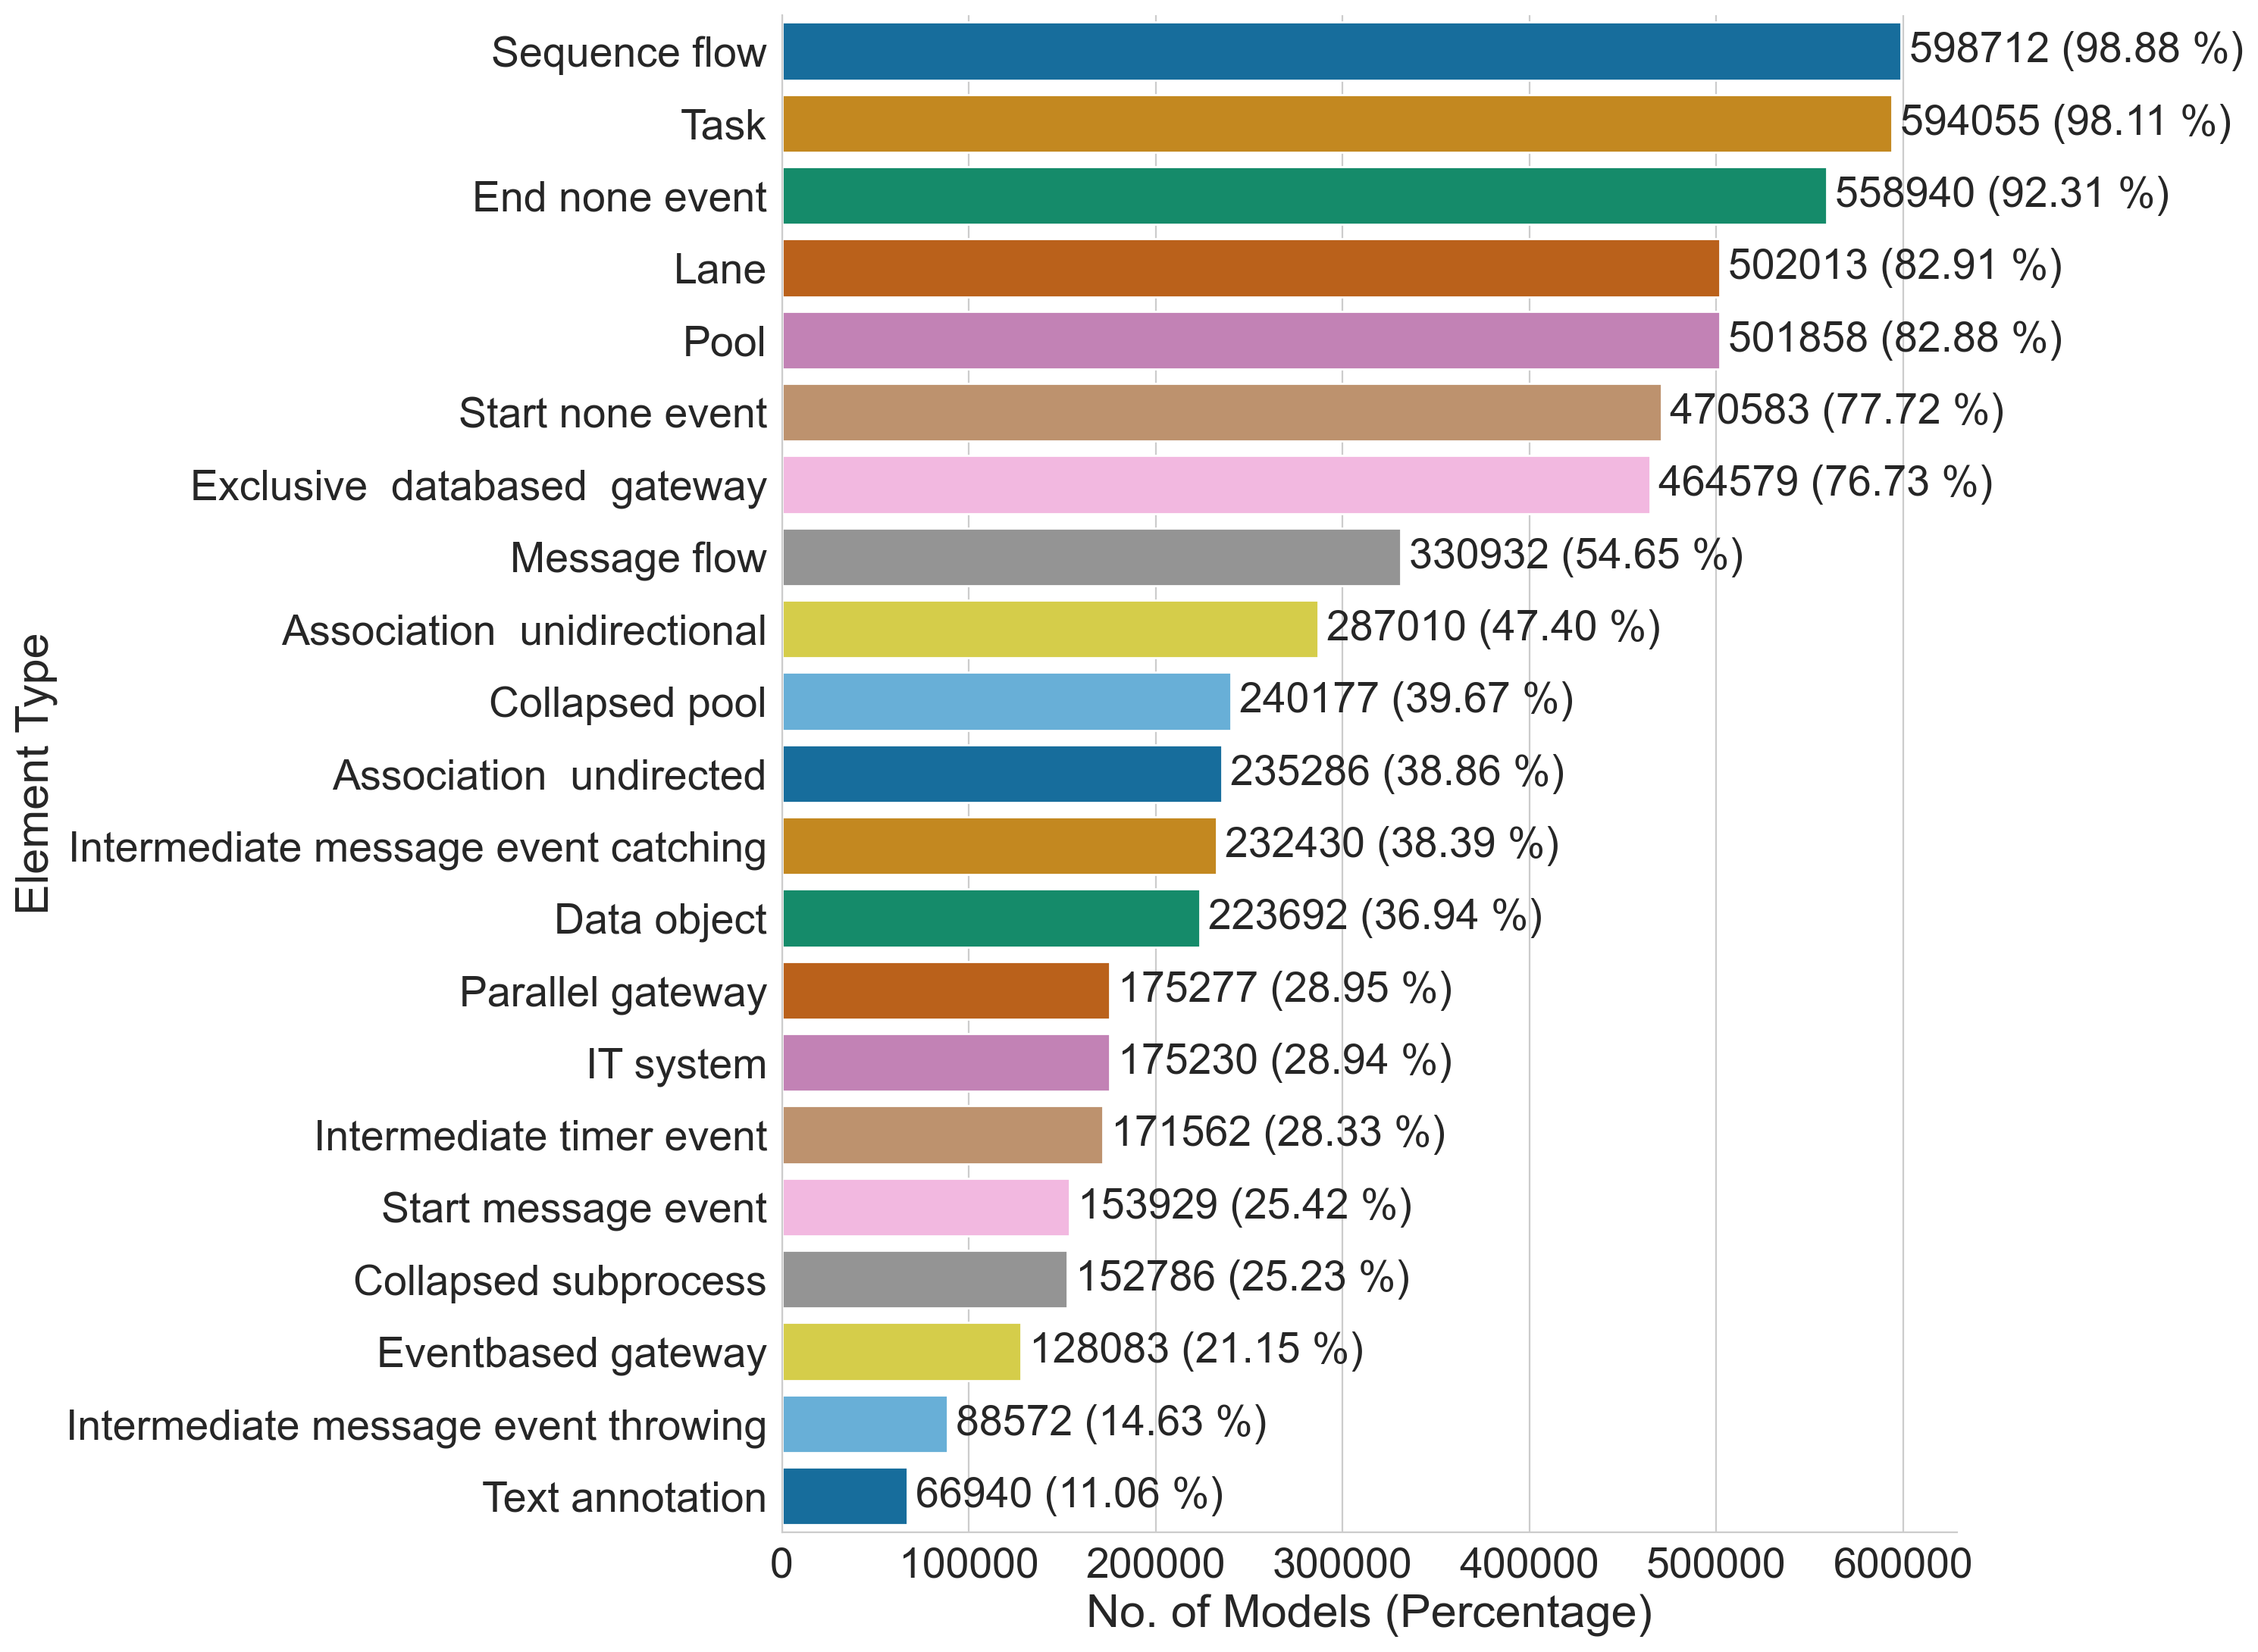

In [47]:
plt.figure(figsize=(10,13)) # 10,13
plt.rcParams.update({'font.size': 20}) # 22
ax = sns.barplot(x="frequency", y="category", data=df_freq, order=df_freq.sort_values('frequency',ascending=False).category,palette=sns.color_palette("colorblind"));
total = len(df_cnts)
ax.bar_label(ax.containers[0],label_type='edge', padding=4, labels=[f'{val} ({val/ total * 100.0:.2f} %)' for val in df_freq['frequency']])
sns.despine()
ax.set_xlabel("No. of Models (Percentage)",fontsize=22)
ax.set_ylabel("Element Type",fontsize=22)
plt.savefig(constants.FIGURES_ROOT / 'elements_usage.pdf',transparent=True,bbox_inches = 'tight')

# Elements

These are the statistics of the number of elements per model:

In [48]:
cnt_elements.total_count.describe()

count    605506.000000
mean         46.727468
std          41.595887
min           1.000000
25%          30.000000
50%          40.000000
75%          48.000000
max        3939.000000
Name: total_count, dtype: float64

These are the statistics of the number of elements per model by element type:

In [49]:
cnt_elements.describe().transpose()

count       mean        std  \
MessageFlow                                605506.0   2.380576   3.343204   
Pool                                       605506.0   1.112182   0.908382   
Lane                                       605506.0   2.076153   1.718778   
StartMessageEvent                          605506.0   0.334700   0.791940   
SequenceFlow                               605506.0  17.769778  16.273840   
EventbasedGateway                          605506.0   0.247271   0.564335   
Task                                       605506.0   8.100686   8.138590   
StartNoneEvent                             605506.0   0.881692   0.740667   
total_count                                605506.0  46.727468  41.595887   
Association_Undirected                     605506.0   1.146149   4.397589   
Association_Unidirectional                 605506.0   1.794499   3.969511   
CollapsedPool                              605506.0   0.451510   0.650938   
IntermediateMessageEventThrowing           605506.0   0.316818   1.180482   
Exclusive_Databased_Gateway                605506.0   2.686370   3.529886   
EndNoneEvent                               605506.0   1.772783   1.474770   
processparticipant                         605506.0   0.171749   0.768785   
IntermediateMessageEventCatching           605506.0   0.852124   1.696936   
DataObject                                 605506.0   0.986662   2.979207   
ITSystem                                   605506.0   0.522963   1.500611   
ParallelGateway                            605506.0   0.704991   1.485428   
StartConditionalEvent                      605506.0   0.010426   0.134901   
IntermediateConditionalEvent               605506.0   0.026961   0.315753   
CollapsedSubprocess                        605506.0   0.402381   1.110718   
EndEscalationEvent                         605506.0   0.076453   0.272304   
IntermediateTimerEvent                     605506.0   0.403187   0.884917   
EndTerminateEvent                          605506.0   0.060847   0.399947   
TextAnnotation                             605506.0   0.401593   3.600701   
Subprocess                                 605506.0   0.071035   0.449420   
IntermediateEvent                          605506.0   0.050431   0.585371   
InclusiveGateway                           605506.0   0.104511   0.544175   
DataStore                                  605506.0   0.202188   0.940155   
EndMessageEvent                            605506.0   0.154747   0.670206   
IntermediateEscalationEvent                605506.0   0.077601   0.280389   
EventSubprocess                            605506.0   0.017318   0.254875   
StartTimerEvent                            605506.0   0.047834   0.282913   
IntermediateErrorEvent                     605506.0   0.039337   0.288347   
IntermediateLinkEventCatching              605506.0   0.011291   0.160623   
IntermediateLinkEventThrowing              605506.0   0.013290   0.193537   
Message                                    605506.0   0.074430   0.735019   
Group                                      605506.0   0.016102   0.283399   
Association_Bidirectional                  605506.0   0.027228   0.391342   
EndErrorEvent                              605506.0   0.020996   0.193434   
IntermediateMultipleEventCatching          605506.0   0.007039   0.117460   
IntermediateSignalEventThrowing            605506.0   0.007138   0.159163   
StartMultipleEvent                         605506.0   0.002926   0.059599   
EndSignalEvent                             605506.0   0.007435   0.150290   
StartSignalEvent                           605506.0   0.006144   0.119018   
IntermediateCancelEvent                    605506.0   0.003580   0.088217   
IntermediateCompensationEventCatching      605506.0   0.008758   0.140780   
EndCancelEvent                             605506.0   0.010436   0.142346   
ComplexGateway                             605506.0   0.005092   0.109659   
VerticalPool                              

The above table is quite large, therefore we summarize it by aggregating the element types to groups and categories as given by the Signavio BPMN 2.0 stencil set specification.

In [50]:
d_low_level_mapping = mappings["element_type_low_level"] # groups
d_high_level_mapping = mappings["element_type_high_level"] # categories

Let's first have a look at the lower level aggregation (groups of similar element types):

In [51]:
df_low_level = cnt_elements.groupby(by=d_low_level_mapping,axis=1).sum()
df_stats = df_low_level.describe().transpose()
df_stats.head()

count       mean        std  min   25%   50%   75%  \
Activities          605506.0   8.594250   8.363516  0.0   4.0   7.0  10.0   
Artifacts           605506.0   0.940658   3.984858  0.0   0.0   0.0   1.0   
Connecting Objects  605506.0  23.118230  21.829501  0.0  14.0  20.0  25.0   
Data Elements       605506.0   1.263281   3.437653  0.0   0.0   0.0   2.0   
Events              605506.0   5.233762   5.098498  0.0   2.0   5.0   6.0   

                       max  
Activities          1543.0  
Artifacts            529.0  
Connecting Objects  2066.0  
Data Elements        266.0  
Events               157.0

In [52]:
df_stats.drop(columns=["count"],inplace=True)
df_stats = df_stats.round(1)
df_stats

mean   std  min   25%   50%   75%     max
Activities           8.6   8.4  0.0   4.0   7.0  10.0  1543.0
Artifacts            0.9   4.0  0.0   0.0   0.0   1.0   529.0
Connecting Objects  23.1  21.8  0.0  14.0  20.0  25.0  2066.0
Data Elements        1.3   3.4  0.0   0.0   0.0   2.0   266.0
Events               5.2   5.1  0.0   2.0   5.0   6.0   157.0
Gateways             3.7   4.4  0.0   2.0   3.0   4.0   303.0
Swimlanes            3.8   2.6  0.0   3.0   4.0   5.0   227.0

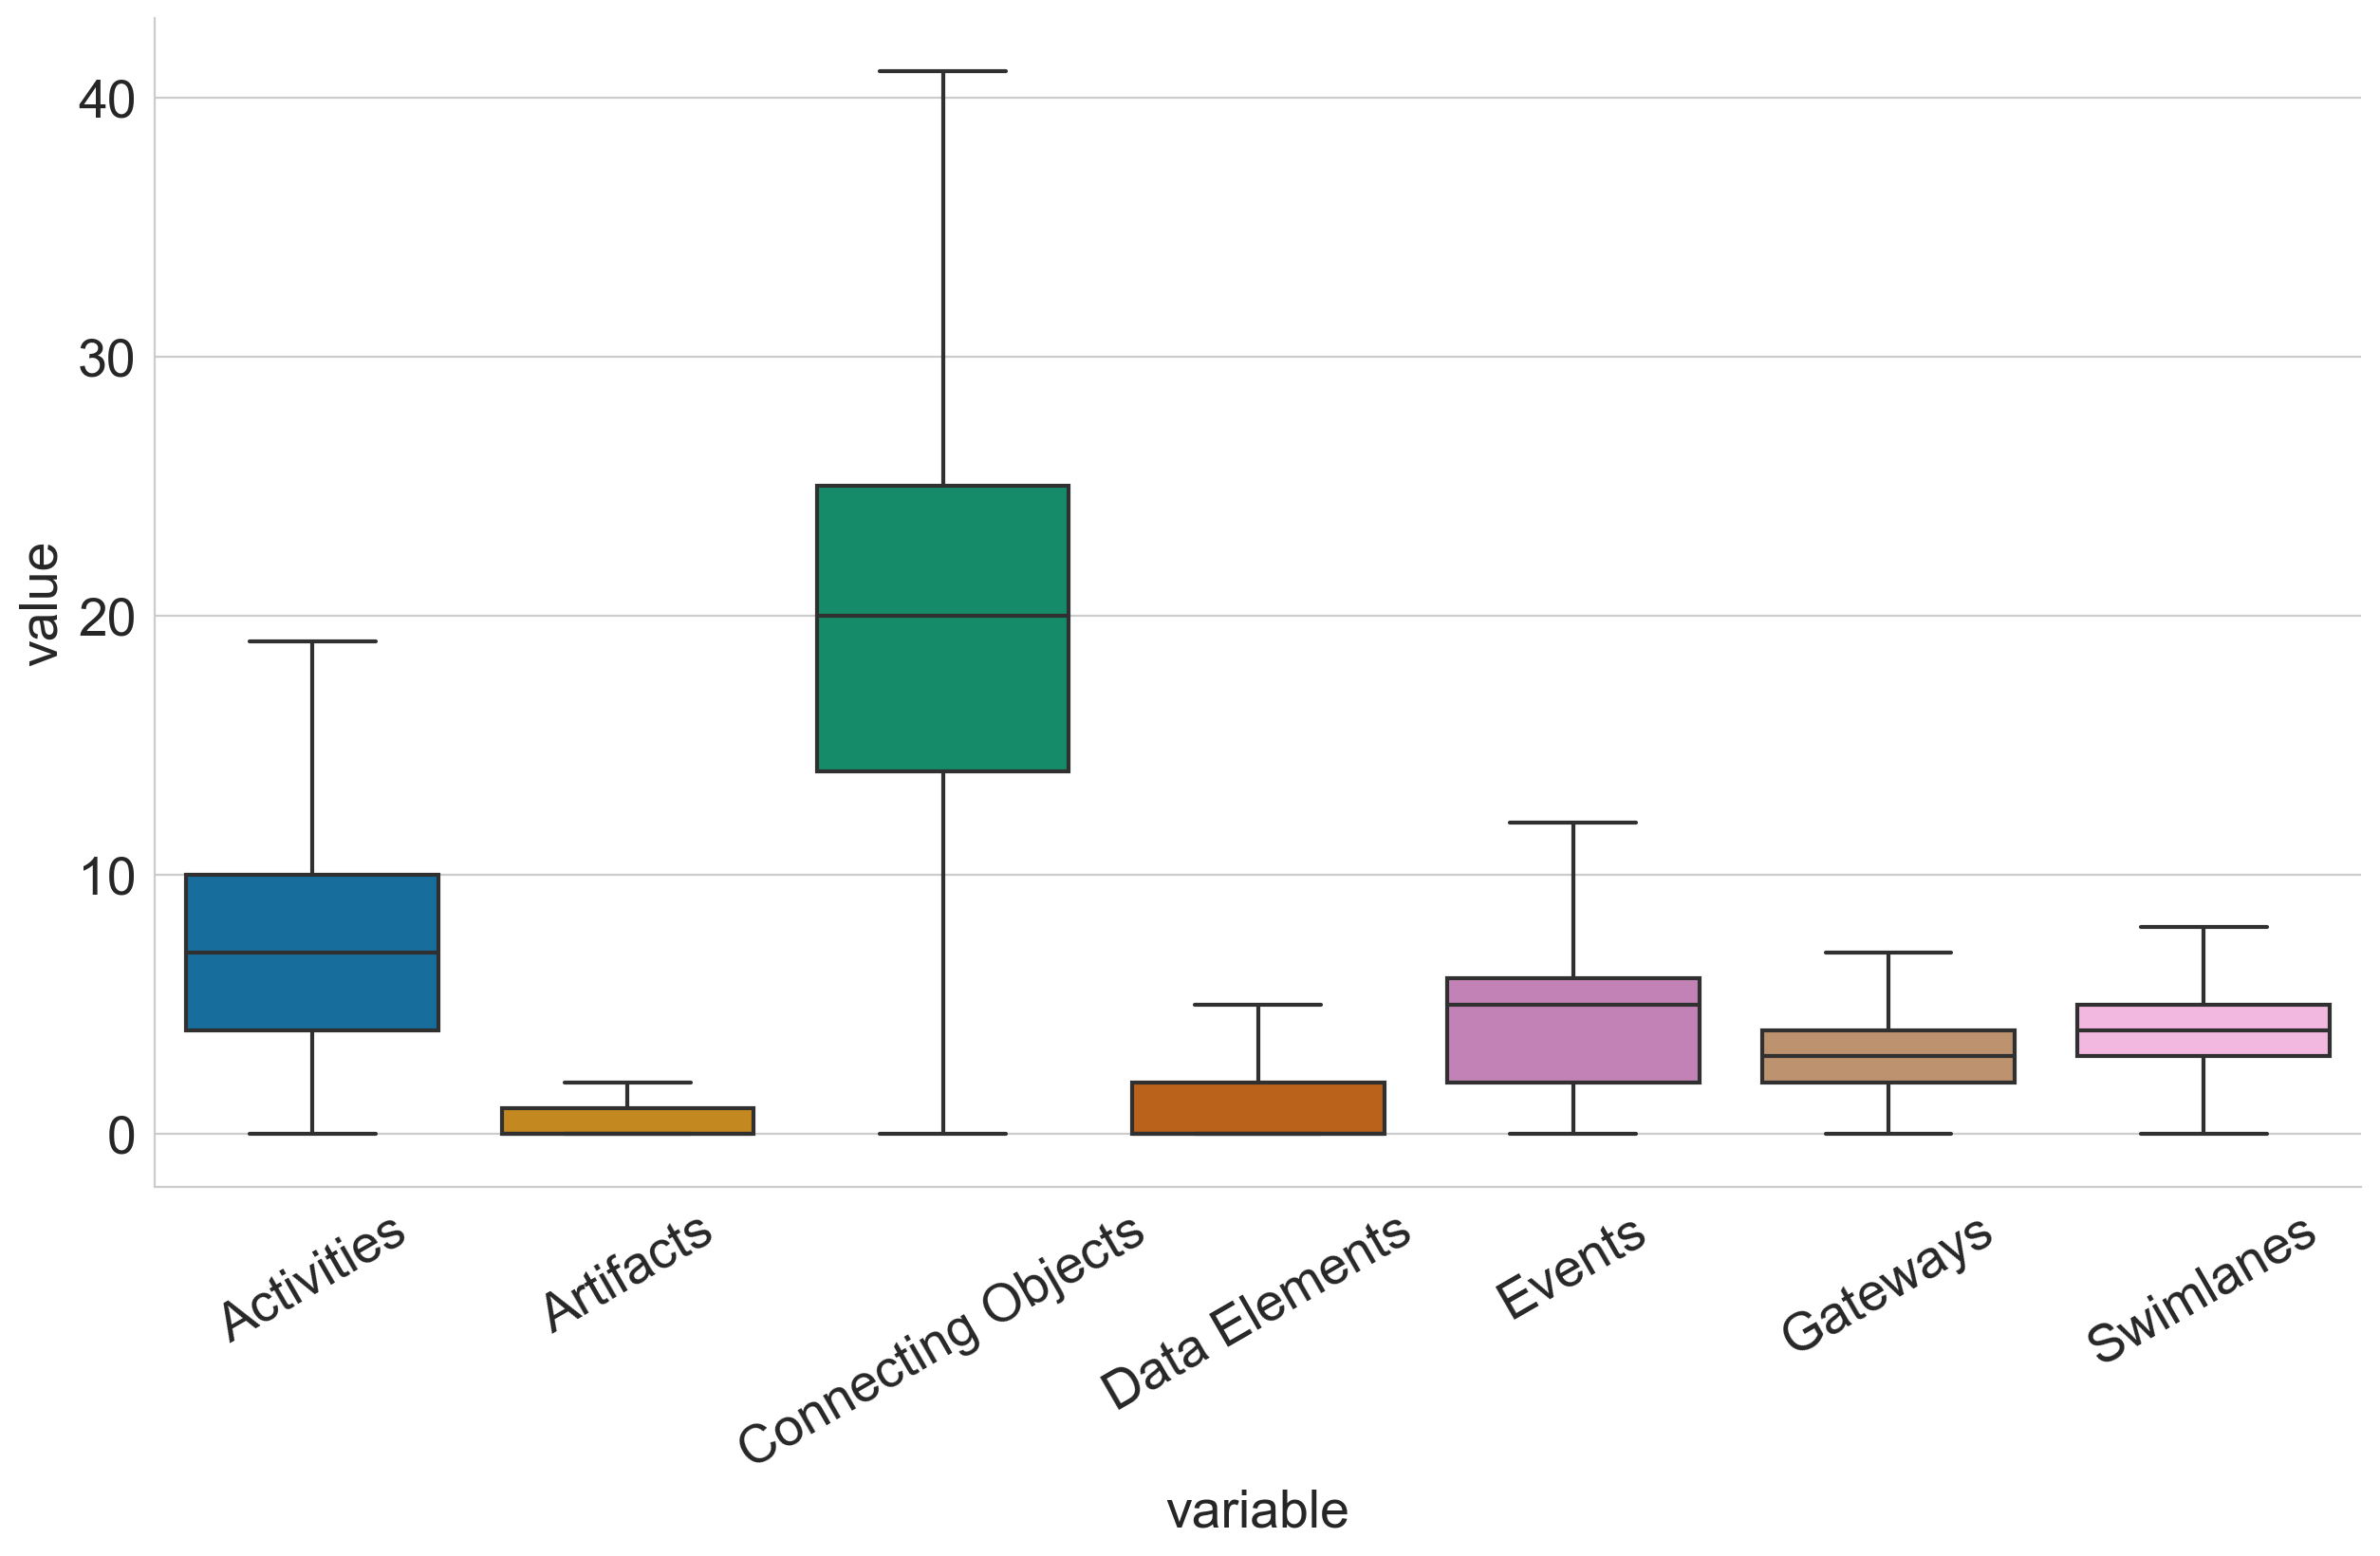

In [53]:
plt.figure(figsize=(15,8))
df_low_level["id"] = df_low_level.index
df_low_level_long = pd.melt(df_low_level, id_vars='id', value_vars=['Activities', 'Artifacts', 'Connecting Objects', 'Data Elements', 'Events', 'Gateways', 'Swimlanes'])
ax=sns.boxplot(x="variable", y="value", data=df_low_level_long,showfliers=False,palette=sns.color_palette("colorblind"))
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
sns.despine()

Now, let's also have a look at a higher level aggregation (categories: nodes and edges).

In [54]:
df_high_level = cnt_elements.groupby(by=d_high_level_mapping,axis=1).sum()
df_high_level.rename(columns={"edge": "No. of Edges", "node": "No. of Nodes"},inplace=True)
df_high_level.describe().transpose()

count       mean        std  min   25%   50%   75%     max
No. of Edges  605506.0  23.118230  21.829501  0.0  14.0  20.0  25.0  2066.0
No. of Nodes  605506.0  23.608565  19.973787  0.0  16.0  20.0  25.0  1873.0

In [55]:
df_high_level.head()

No. of Edges  No. of Nodes
0             3             9
1            25            22
2            17            21
3             6             7
4            29            37

The number of nodes and edges is naturally highly correlated:

<Figure size 500x500 with 0 Axes>

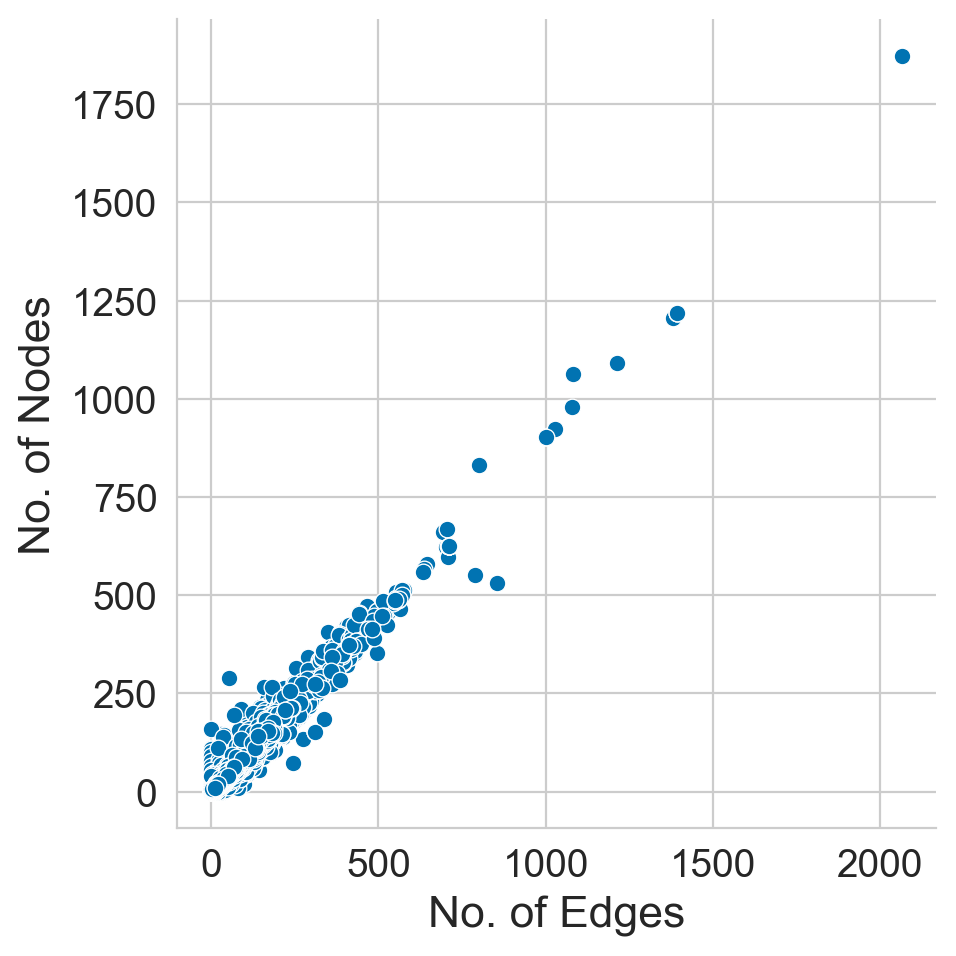

In [56]:
plt.figure(figsize=(5,5))
plt.rcParams.update({'font.size': 14,'axes.labelsize': 16})
ax = sns.relplot(data=df_high_level.astype(float), x = "No. of Edges", y = "No. of Nodes",color=sns.color_palette("colorblind",as_cmap=True)[0])
sns.despine()
plt.savefig(constants.FIGURES_ROOT / 'correl_plot.png',transparent=True,bbox_inches = 'tight',dpi=300)

# Process names 

Let's now have a look at the process names.

A function for cleaning the names or labels (if required for the use case):

In [57]:
def clean(label):
    # handle some special cases
    label = label.replace("\n", " ").replace("\r", "")
    label = label.replace("(s)", "s")
    # turn any non alphanumeric characters into whitespace
    # label = re.sub("[^A-Za-z]"," ",label)
    # delete unnecessary whitespaces
    label = label.strip()
    label = re.sub("\s{1,}"," ",label)
    # make all lower case
    label = label.lower()
    return label

def alphanumeric(label):
    return re.sub("[^A-Za-z]"," ",label)

In [58]:
cnts_names = dict(Counter(df_meta['name'].values))
#cnts_names = dict(Counter(df_meta['name'].apply(lambda x: clean(str(x))).values))
cnts_names = pd.DataFrame.from_dict(cnts_names.items())
cnts_names.columns = ['name', 'occurrences']
cnts_names = cnts_names.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_names.head(10)

name  occurrences
0            12345678        24296
1         New Process        13268
2       Neuer Prozess         4756
3       12345678_rev1         2494
4       12345678_rev2         1530
5            Jane Doe         1351
6         New Diagram         1218
7       12345678_rev3         1118
8  New Process (Copy)          746
9       12345678_rev4          745

The number of distinct process names:

In [59]:
len(cnts_names)

328280

We use Signavio's color palette for the word cloud.

In [60]:
import random
colors = constants.COLORS_SIGNAVIO_HSL 
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return random.choice(colors)

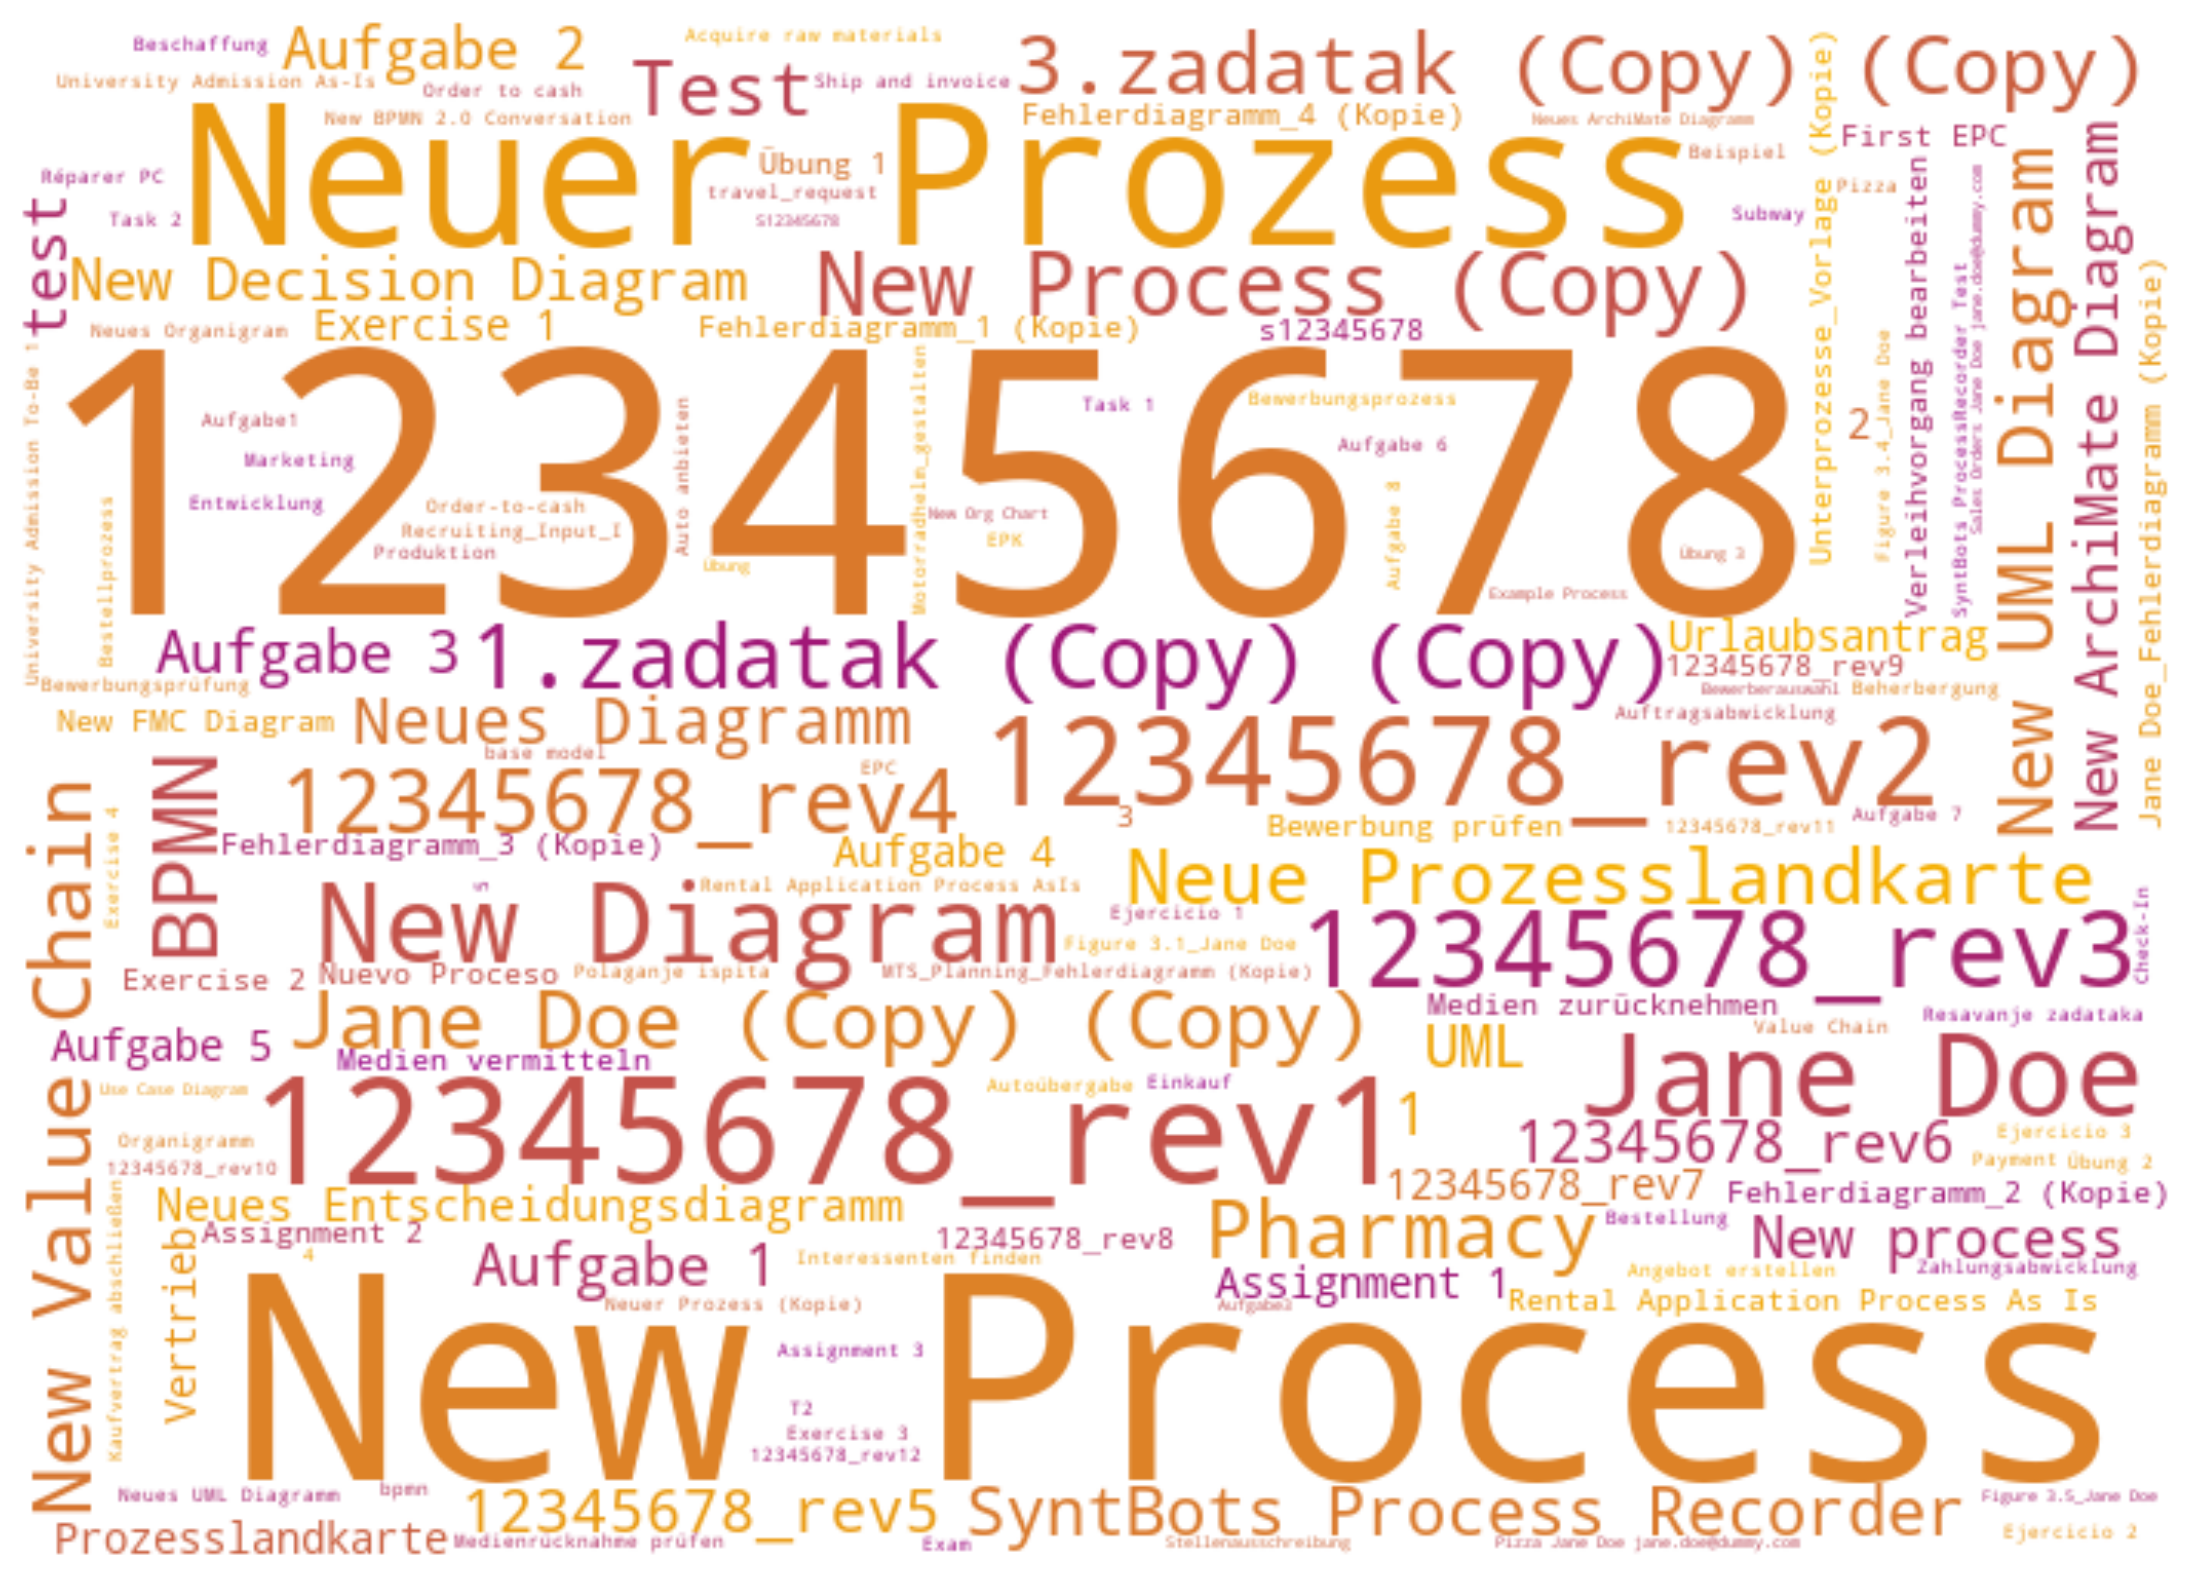

In [61]:
wordcloud_dict_names = dict(zip(cnts_names.name, cnts_names.occurrences))
wordcloud = WordCloud(min_word_length=1,background_color='white',width=700, height=500)
wordcloud = wordcloud.generate_from_frequencies(wordcloud_dict_names)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_process_names.pdf',transparent=True,bbox_inches = 'tight')
plt.show()

It seems like the word cloud is dominated by the process names of the examples processes that are added to each newly created workspace.

# Labels

Let's also investigate element labels.

In [62]:
# cnts_labels = dict(Counter(df_bpmn['label'].apply(lambda x: clean(str(x))).values))
cnts_labels = dict(Counter(df_bpmn['label'].values))
cnts_labels = pd.DataFrame.from_dict(cnts_labels.items())
cnts_labels.columns = ['label', 'occurrences']
cnts_labels = cnts_labels.sort_values(by=['occurrences'],ignore_index=True,ascending=False)
cnts_labels = cnts_labels[~cnts_labels.label.isin([None,""])]
cnts_labels.reset_index(drop=True, inplace=True)
cnts_labels.head(10)

label  occurrences
0                            ACME AG       215731
1                                 No       179073
2                                Yes       158314
3                         ERP-System       139391
4                           Supplier        99560
5                                 no        79254
6                                yes        70321
7                        Procurement        64664
8         Human Resources Department        64008
9  Specify and quantify requirements        63714

The number of distinct element labels:

In [63]:
len(cnts_labels)

2820531

2.820.531 labels are used for the 28.293.762 elements in the BPMN models:

In [64]:
len(df_bpmn)

28293762

10 % of the unique labels make up for more than 74.0 % of the element labels ...

In [65]:
sum(cnts_labels.occurrences[:int(len(cnts_labels)*0.1)])/sum(cnts_labels.occurrences)

0.7405454866714983

... while 64.9 % of the labels are used for only one element.

In [66]:
len(cnts_labels[cnts_labels.occurrences==1])/len(cnts_labels)

0.6487753547115773

In [67]:
len(cnts_labels[cnts_labels.occurrences==1])

1829891

Let's visualize the distribution of the label usage frequency in BPMN 2.0 models.

In [68]:
bins = cnts_labels
bins.head()

label  occurrences
0     ACME AG       215731
1          No       179073
2         Yes       158314
3  ERP-System       139391
4    Supplier        99560

We sort the labels based on their absolute usage frequency in descending order and group them in bins of size 10,000 to visualize the unevenness of the distribution.

In [69]:
N = 10000
bins = bins.groupby(bins.index // N).sum()

In [70]:
import math

bins["bins of labels"] = [N*i for i in range(1,math.ceil(len(cnts_labels)/N)+1)]
bins.head()

occurrences  bins of labels
0      7375127           10000
1       461098           20000
2       287191           30000
3       212010           40000
4       170849           50000

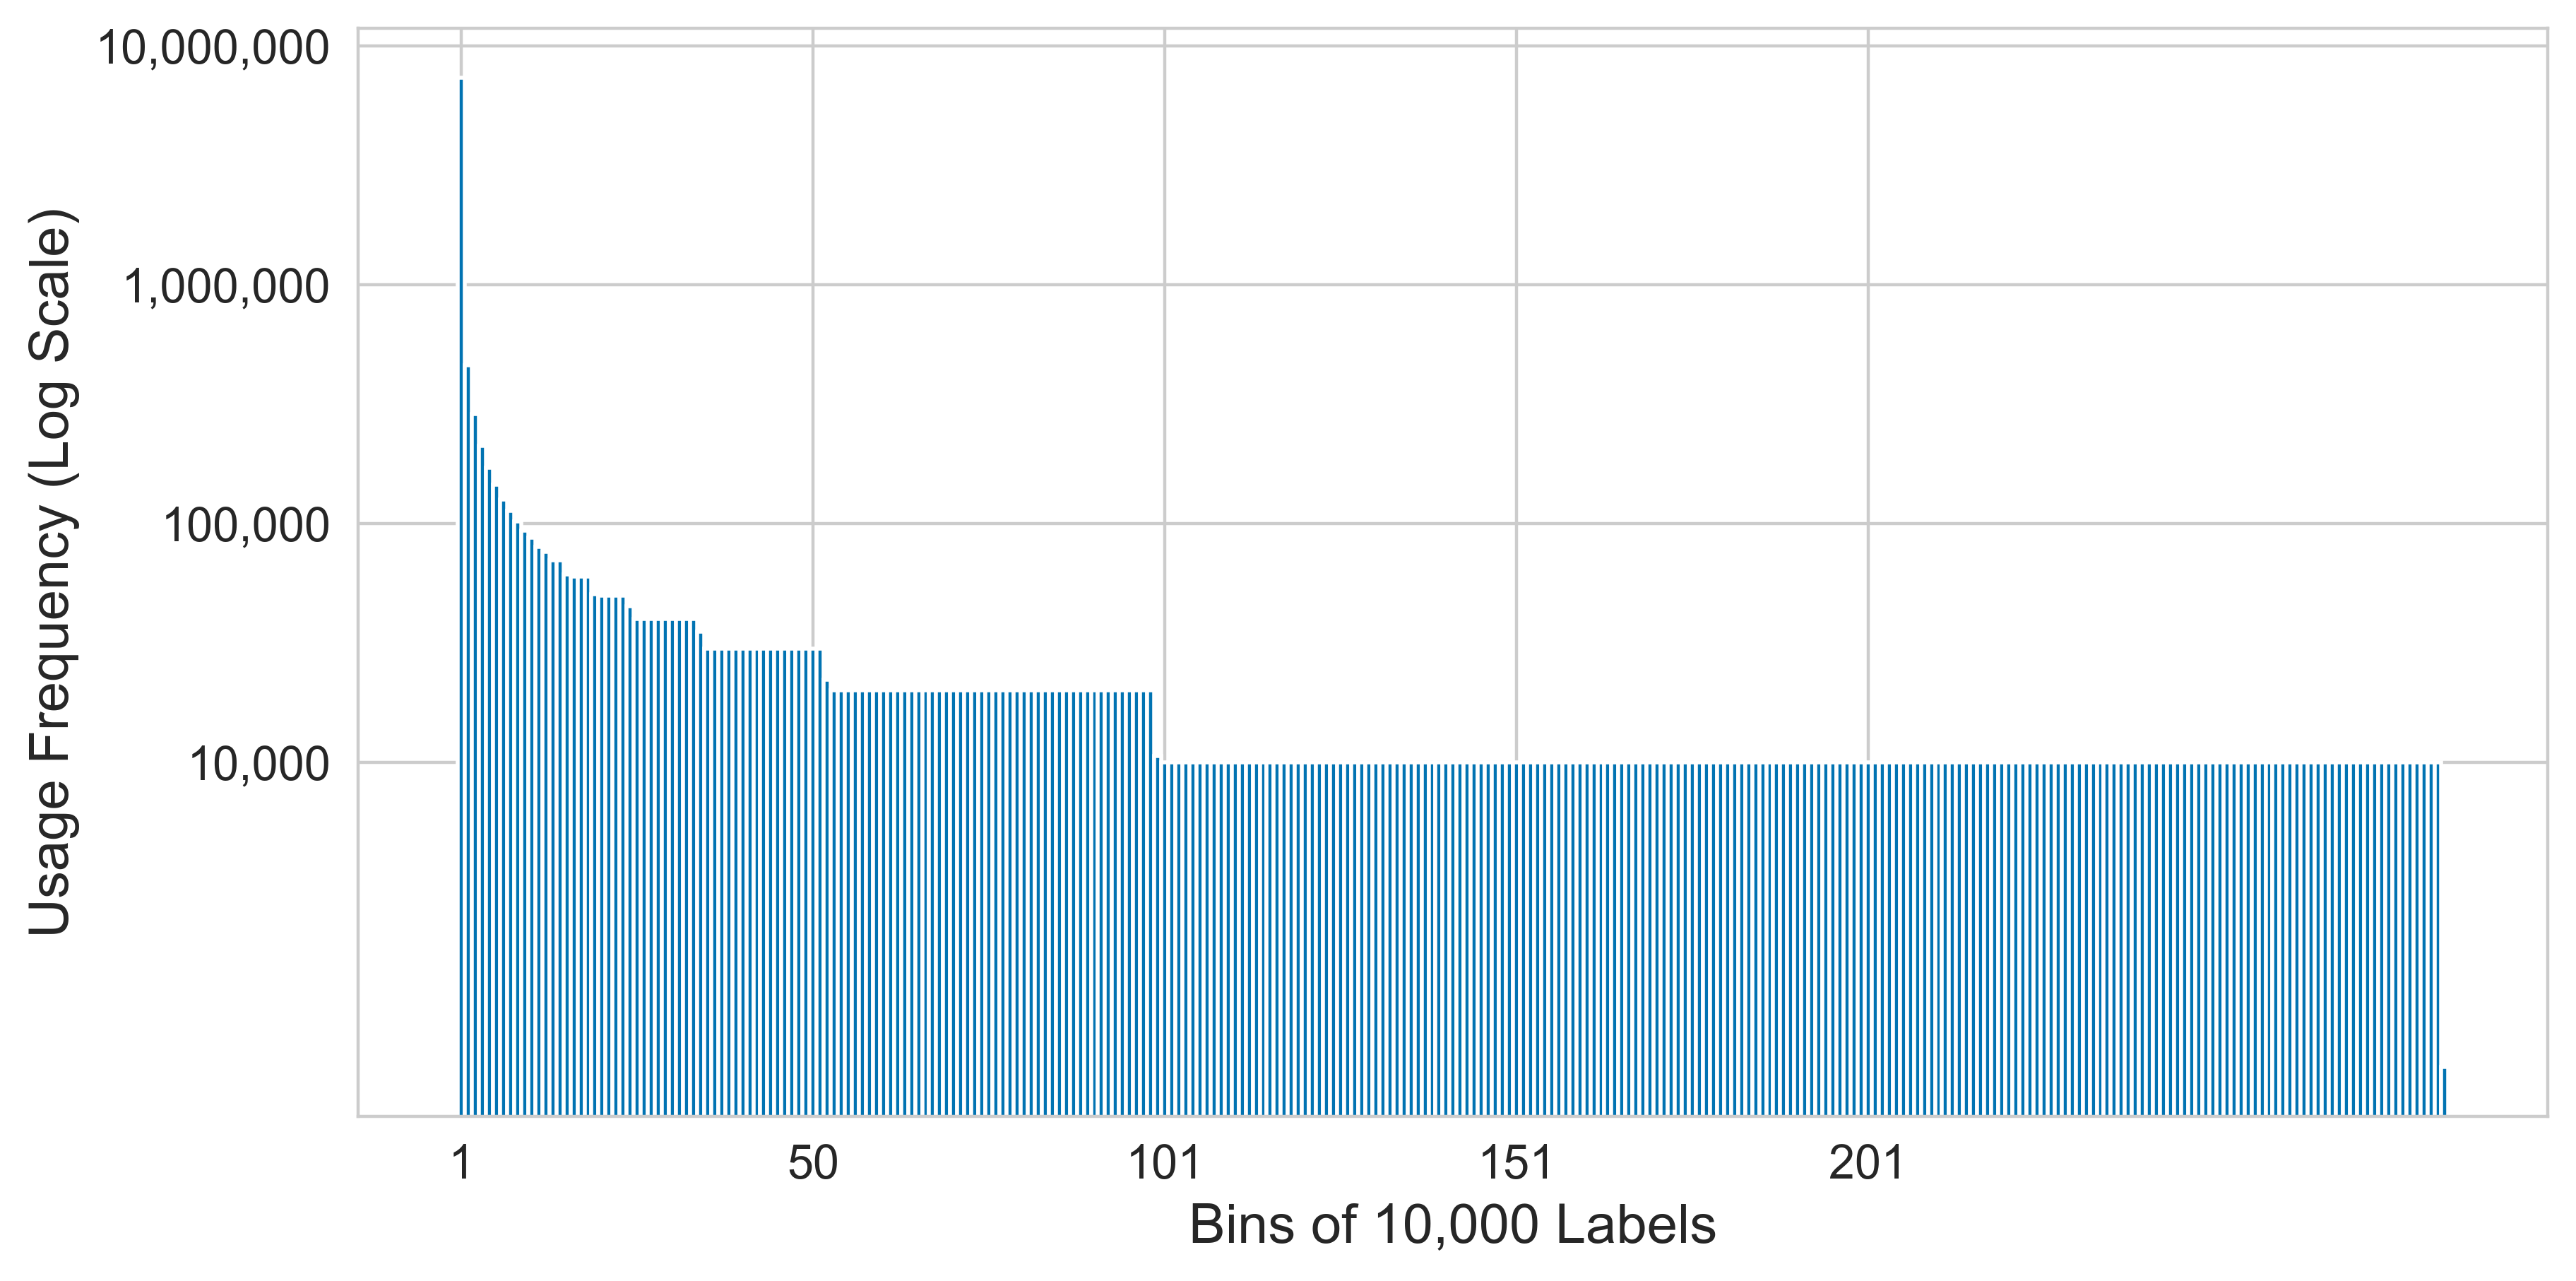

In [71]:
nb_of_bins = len(bins)
plt.figure(figsize=(10,5),dpi=200)
plt.rcParams.update({'font.size': 12,'axes.labelsize': 14})
ax=plt.bar([i for i in range(0,nb_of_bins)],height=list(bins["occurrences"]),width=1,color=sns.color_palette("colorblind",as_cmap=True)[0])
plt.yscale('log')
plt.xticks([0,50,100,150,200], ["1","50","101","151","201"])
plt.yticks(np.array([1.e+04, 1.e+05, 1.e+06, 1.e+07]),["10,000","100,000","1,000,000","10,000,000"])
plt.xlabel("Bins of 10,000 Labels")
plt.ylabel("Usage Frequency (Log Scale)")
plt.savefig(constants.FIGURES_ROOT / 'labels_usage.pdf',transparent=True,bbox_inches = 'tight')

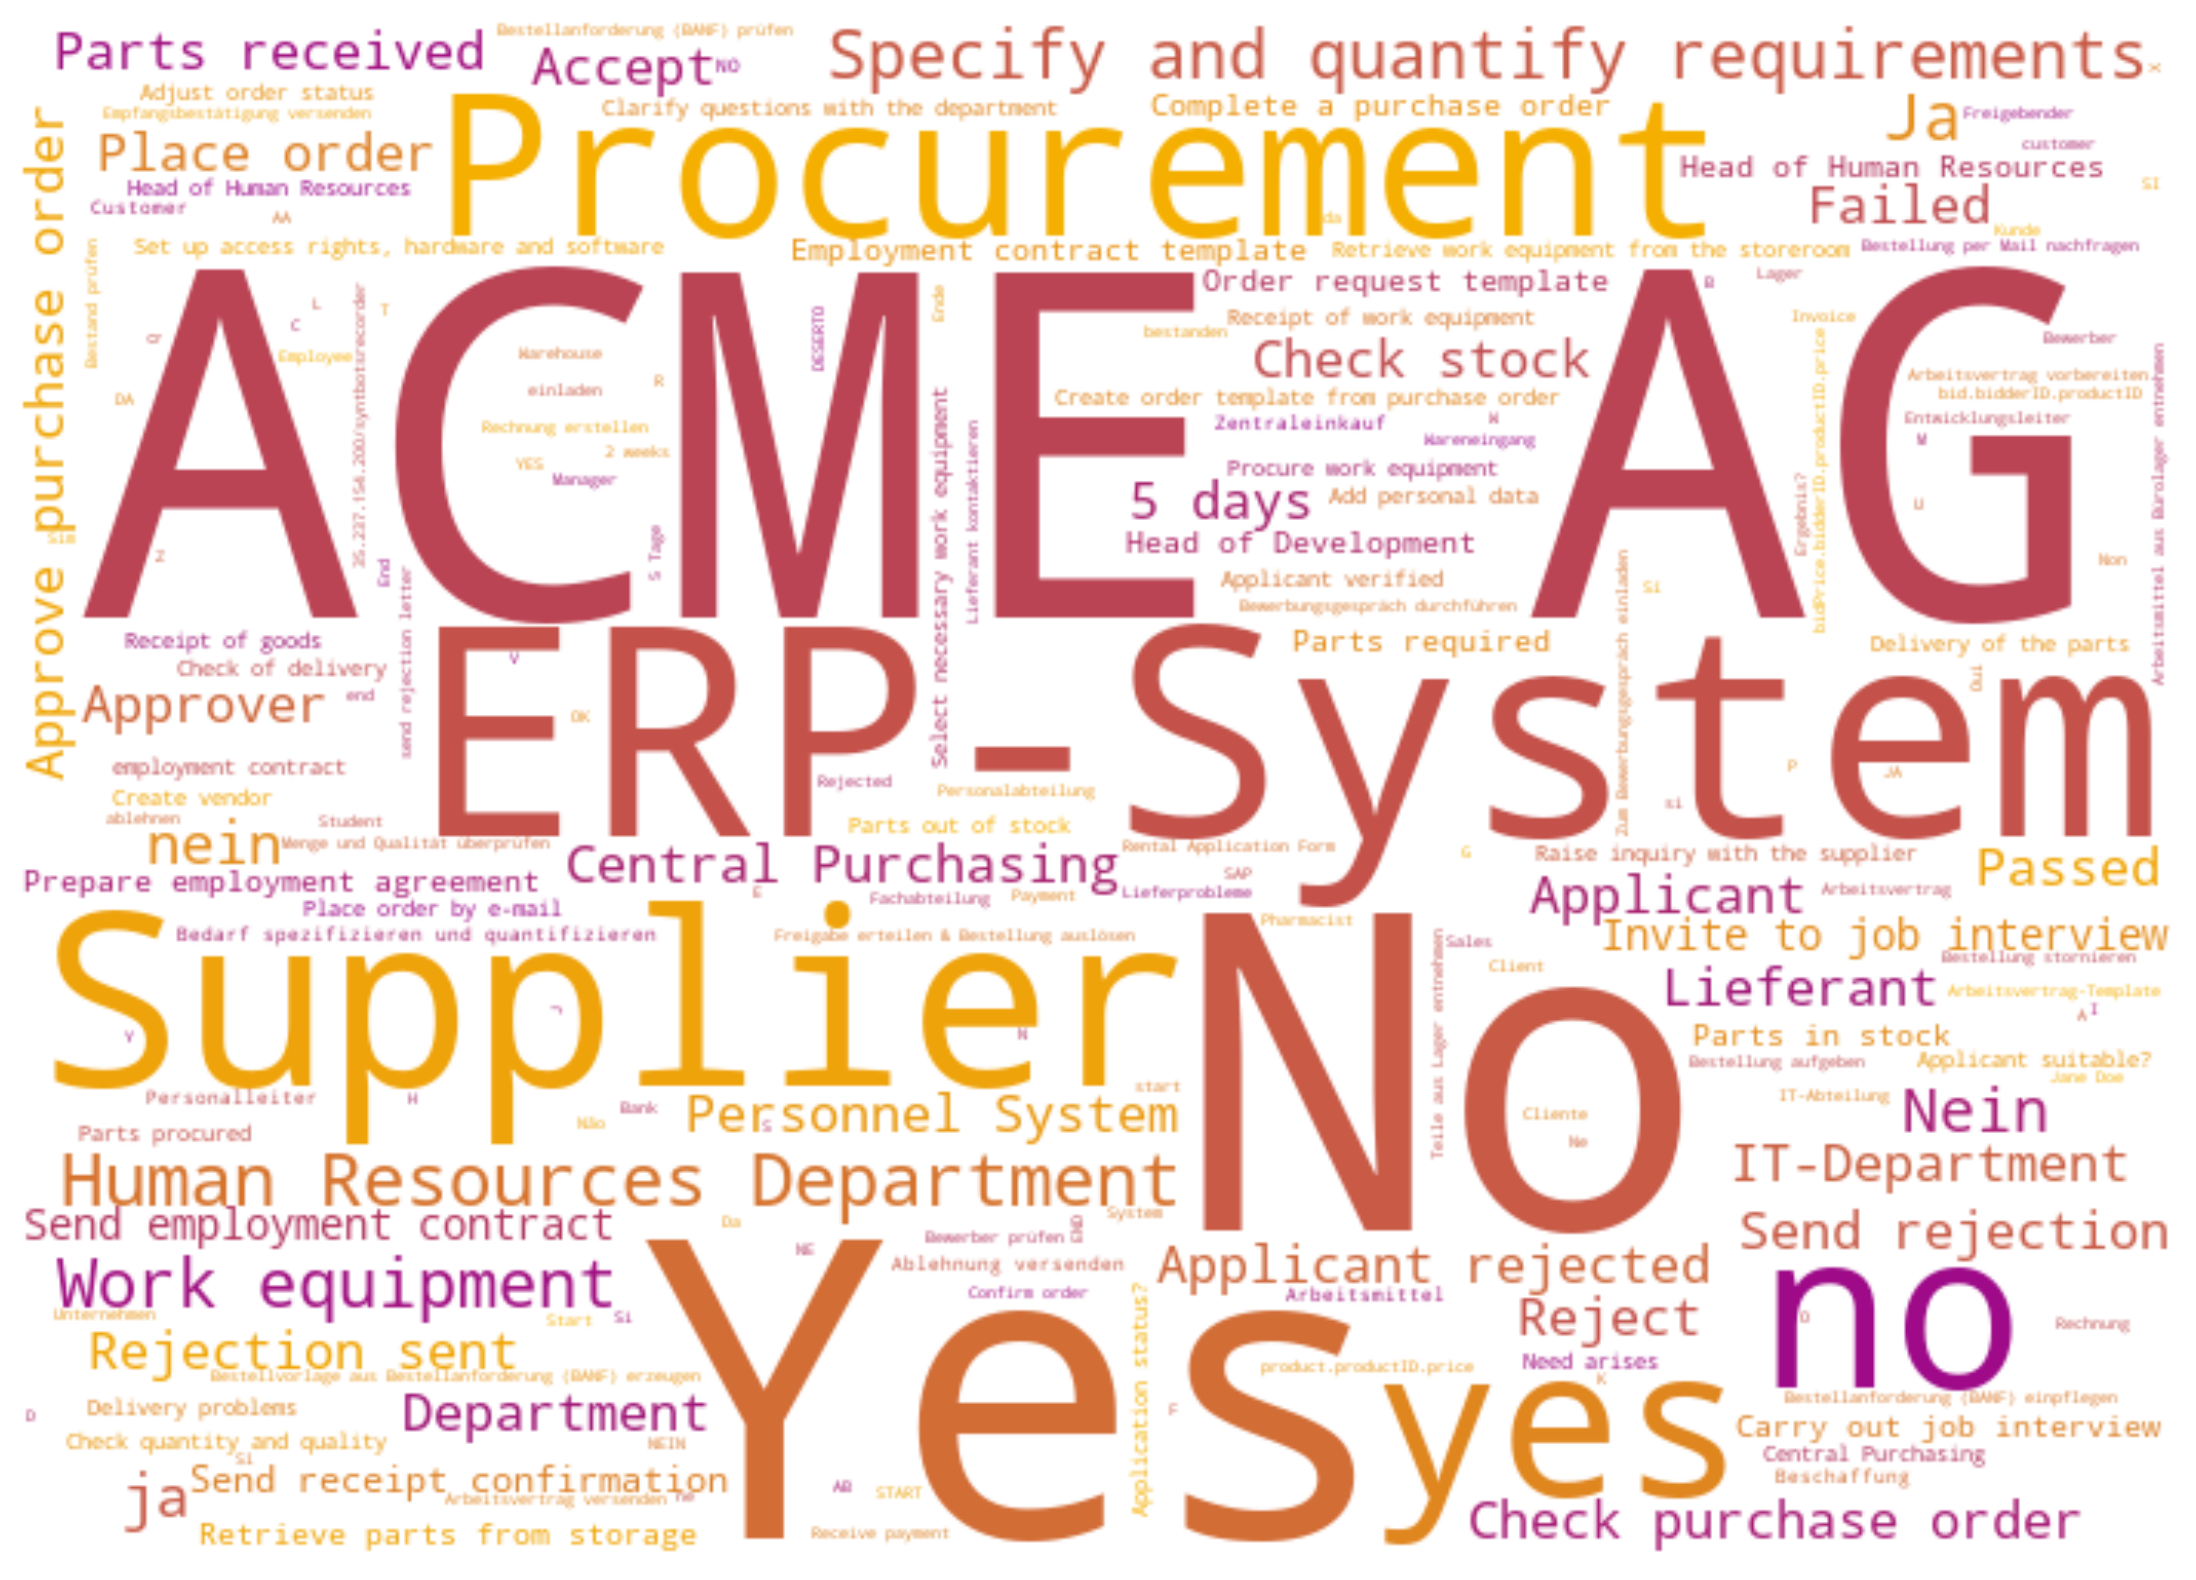

In [72]:
wordcloud_dict_labels = dict(zip(cnts_labels.label, cnts_labels.occurrences))
wordcloud_dict_labels = {k: v for k, v in wordcloud_dict_labels.items() if '\n' not in k}
wordcloud = WordCloud(min_word_length=2,background_color='white',width=700, height=500)
wordcloud.generate_from_frequencies(wordcloud_dict_labels)
plt.figure(figsize=(20,10))
plt.imshow(wordcloud.recolor(color_func = color_func), interpolation='bilinear')
plt.axis('off')
plt.savefig(constants.FIGURES_ROOT / 'word_cloud_labels.pdf',transparent=True,bbox_inches = 'tight')
plt.show()